In [ ]:
# Determinism env (set before Torch ops for cuBLAS determinism)
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
from datasets import load_dataset

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")
# for cuBLAS determinism

try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HookedTransformer.from_pretrained("gpt2-small").to(device).eval()


Using device: cuda


/workspace/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [9]:
PREPEND_BOS = True
prefix = "The doctor said that "

# Tokenize once for the main prefix; used by the sanity check
toks_prefix = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)

# Token IDs for the contrastive pair
he_id = int(model.to_tokens(" he", prepend_bos=False)[0, 0])
she_id = int(model.to_tokens(" she", prepend_bos=False)[0, 0])

# Injection and readout configuration
INJECT_SITE = "hook_resid_mid"
READ_SITE = "hook_resid_post"

# Alpha sweep grid
# ALPHA_RANGE = np.array(np.arange(-1, 1, 0.1), dtype=float)
ALPHA_RANGE = np.array(np.arange(-10, 10, 0.5), dtype=float)


# inject and read layers
INJECT_LAYERS = list(range(model.cfg.n_layers))
READ_LAYERS = list(range(model.cfg.n_layers))


In [10]:
# Load the HuggingFace Winogender dataset and convert to a DataFrame
# has only one split labeled "test" for some reason
dataset = load_dataset("oskarvanderwal/winogender", 'all')
df = (dataset["test"].to_pandas())[["gender", "sentence", "occupation"]]

# Filter down to only male and female
df = df[df["gender"].isin(["female", "male"])]

# Group by occupation & pronoun, take the first row in each group then drop occupation col
df = (
    df
    .groupby(["occupation", "gender"], as_index=False)
    .first()
)

# Create pairs of (female_prompt, male_prompt) for the same occupation
# TODO can be made more efficient
female_df = df[df["gender"] == "female"].set_index("occupation")
male_df = df[df["gender"] == "male"].set_index("occupation")
prompt_pairs = [(female_df.loc[occ, "sentence"], male_df.loc[occ, "sentence"])
                for occ in female_df.index if occ in male_df.index]

print("Number of contrastive pairs: ", df.shape[0])


Number of contrastive pairs:  120


In [11]:
@torch.no_grad()
def residual_at_last_token(prompt: str, layer: int, site: str = INJECT_SITE):
    """
    Args:
        prompt: str, the prompt to tokenize 
        layer: int, the layer to inject the vector
        site: str, the site to inject the vector
    Returns:
        torch.Tensor, the residual stream at the LAST token
    """

    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)

    cache = {}

    def grab(activation, hook):
        cache["resid"] = activation.detach()
        return activation

    _ = model.run_with_hooks(toks, return_type=None, stop_at_layer=layer +
                             1, fwd_hooks=[(f"blocks.{layer}.{site}", grab)])

    return cache["resid"][0, toks.shape[1] - 1, :].clone().to(device)


In [ ]:
def build_vectors(inj: int, prompt_pairs: list[tuple[str, str]]) -> dict[str, torch.Tensor]:
    """
    Build bias, random, and orthogonal vectors for a given injection layer.
    """
    def unit(x): return x / (x.norm() + 1e-8)

    # Build bias vector
    v_bias = torch.stack([
        residual_at_last_token(p[0], inj) - residual_at_last_token(p[1], inj)
        for p in prompt_pairs
    ]).mean(dim=0)
    v_bias = unit(v_bias)

    # Generate random and orthogonal vectors
    v_rand = unit(torch.randn_like(v_bias))
    v_orth = unit(v_rand - (v_rand @ v_bias) * v_bias / (v_bias @ v_bias))

    return {"bias": v_bias, "random": v_rand, "orth": v_orth}


In [13]:
@torch.no_grad()
def get_steered_logits(prompt: str, steer_vec: torch.Tensor, alpha: float, inject_hook_name: str, read_hook_name: str, inject_layer: int, read_layer: int) -> torch.Tensor:
    """Return Δ_logit = logit(stereo) − logit(anti) at the pronoun position under a clean logit lens.
    Does not change model weights; only adds a steer_vec at the configured injection site during the forward pass.
    Args:
        prompt: str, the prompt to steer
        steer_vec: torch.Tensor, the vector to steer the model with
        alpha: float, the strength of the steer
        inject_hook_name: str, the name of the hook to inject the steer_vec
        read_hook_name: str, the name of the hook to read the model
        inject_layer: int, the layer to inject the steer_vec
    Returns:
        torch.Tensor, the logits of the model after steering []
    """
    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)
    last_token_idx = toks.shape[1] - 1
    cache = {}

    def do_steer(act, hook):
        vec = steer_vec.to(act.device)
        act[:, last_token_idx, :] = act[:, last_token_idx, :] + (alpha * vec)
        return act

    def do_read(act, hook):
        cache["resid"] = act.detach().clone()
        return act

    _ = model.run_with_hooks(
        toks, return_type=None,
        stop_at_layer=max(inject_layer, read_layer) + 1,
        fwd_hooks=[(inject_hook_name, do_steer), (read_hook_name, do_read)]
    )  # set to _ to debug

    resid = model.ln_final(
        cache["resid"][:, last_token_idx: last_token_idx + 1, :])  # [1, 1, vocab_size]

    logits = model.unembed(resid)[0, 0, :]  # [1, vocab_size]

    return logits


In [ ]:
@torch.no_grad()
def sweep_alpha(vector: torch.Tensor, alpha_grid: list[float], prompt: str, inj_layer: int, read_layer: int, inject_hook_name: str, read_hook_name: str) -> list[torch.Tensor]:
    """
    Sweep across alpha grid one pairing of inject and read layers.
    returns list of logits for each alpha in alpha_grid
    """
    logits = []
    for alpha in alpha_grid:
        logits.append(get_steered_logits(prompt, vector, alpha,
                      inject_hook_name, read_hook_name, inj_layer, read_layer))

    return logits


In [43]:
# Helper plotting and saving
def plot_and_save(bias_diffs, random_diffs, orth_diffs, inj, read):
    """
    Plot and save the BRC curves for the given injection and read layers.

    Inputs:
        bias_diffs   : sequence[float] — Δlogit values for the bias vector
        random_diffs : sequence[float] — Δlogit values for the random vector
        orth_diffs   : sequence[float] — Δlogit values for the orthogonal vector
        inj          : int — injection layer index
        read         : int — read layer index
    """
    # --- Config (unchanged styling/colors) ---
    colors = {
        "bias":   ("#0072B2", 2.5),
        "random": ("#D55E00", 2.0),
        "orth":   ("#009E73", 2.0),
    }

    series = {
        "bias":   list(bias_diffs),
        "random": list(random_diffs),
        "orth":   list(orth_diffs),
    }

    # --- Figure style setup ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))

    # --- Plot each series ---
    for name in ["bias", "random", "orth"]:
        color, lw = colors[name]
        ax.plot(
            ALPHA_RANGE, series[name],
            label=name, color=color,
            linewidth=lw, marker="o", markersize=3
        )

    # --- Axes decoration ---
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel(r"Steering coefficient $\alpha$", fontsize=14)
    ax.set_ylabel(
        r"$\Delta_{\mathrm{logit}} = \mathrm{logit}(\text{He}) - \mathrm{logit}(\text{She})$",
        fontsize=14
    )
    ax.set_title(
        f"BRC | inject: L{inj}:{INJECT_SITE} → read: L{read}:{READ_SITE}",
        fontsize=15, weight="bold"
    )
    ax.legend(frameon=True, fontsize=11)
    ax.tick_params(axis="both", which="major", labelsize=12)

    note = f"BOS={PREPEND_BOS}, prefix='{prefix}'"
    ax.text(0.01, -0.14, note, transform=ax.transAxes, fontsize=10, color="gray")

    # --- Y-axis-limits ---
    yvals = series["bias"] + series["random"] + series["orth"]
    if yvals:
        ymin, ymax = min(yvals), max(yvals)
        if ymax == ymin:
            pad = 0.1 if ymax == 0 else abs(ymax) * 0.1
            ax.set_ylim(ymin - pad, ymax + pad)
        else:
            yr = ymax - ymin
            ax.set_ylim(ymin - 0.1 * yr, ymax + 0.1 * yr)

    plt.tight_layout()

    # --- Save ---
    out_dir = os.path.join("graphs", f"injL{inj}")
    os.makedirs(out_dir, exist_ok=True)
    fig_path = os.path.join(
        out_dir, f"brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png"
    )
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fig_path)

In [48]:
# run this whenever you want to reproduce the same results (use 42)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


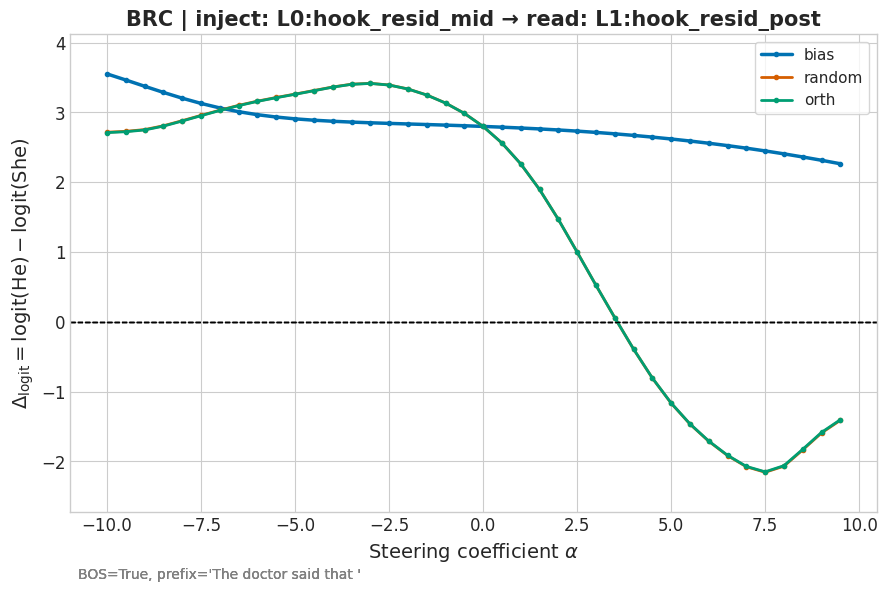

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL1_hook_resid_post.png


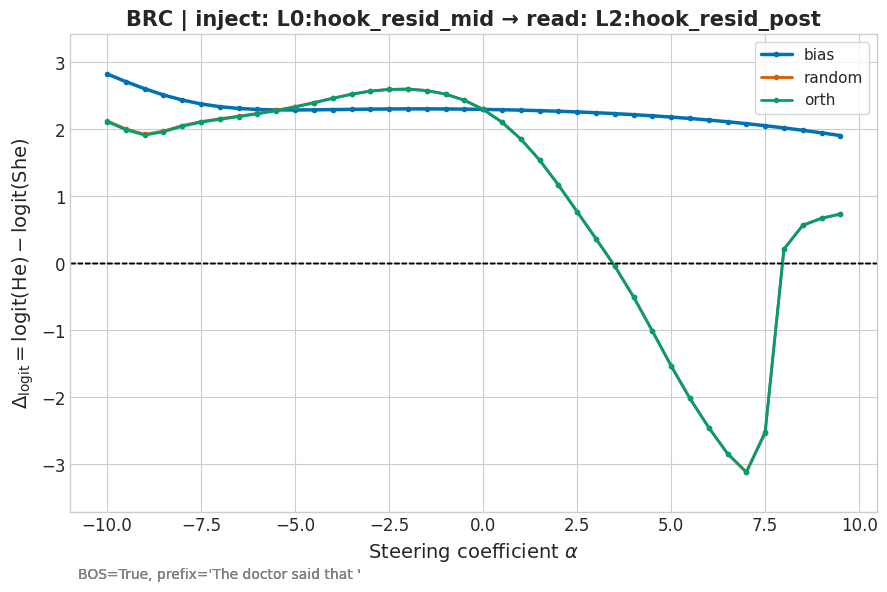

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL2_hook_resid_post.png


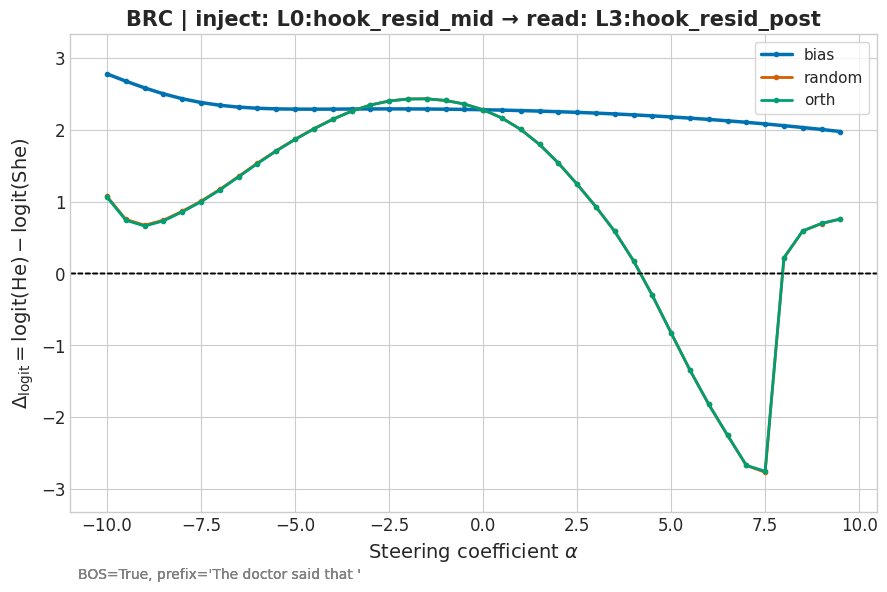

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL3_hook_resid_post.png


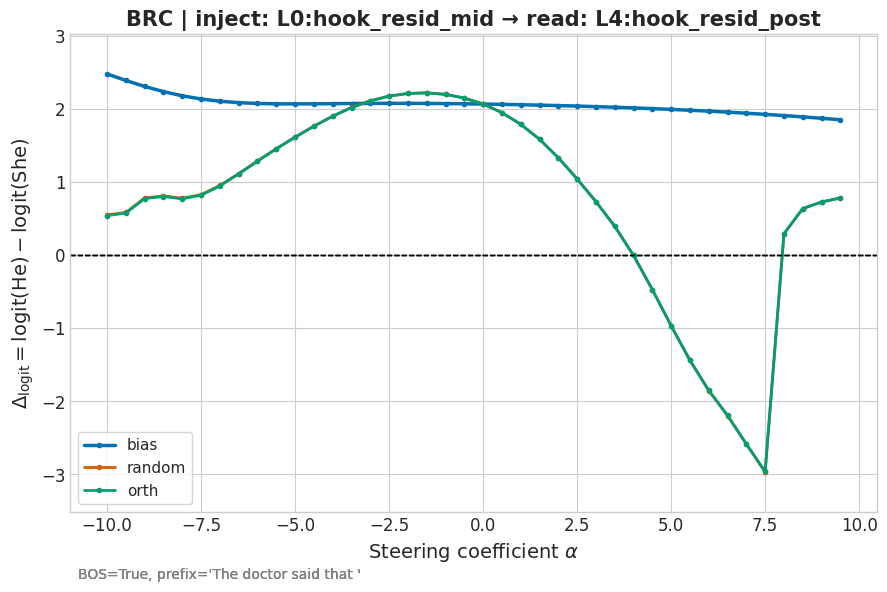

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL4_hook_resid_post.png


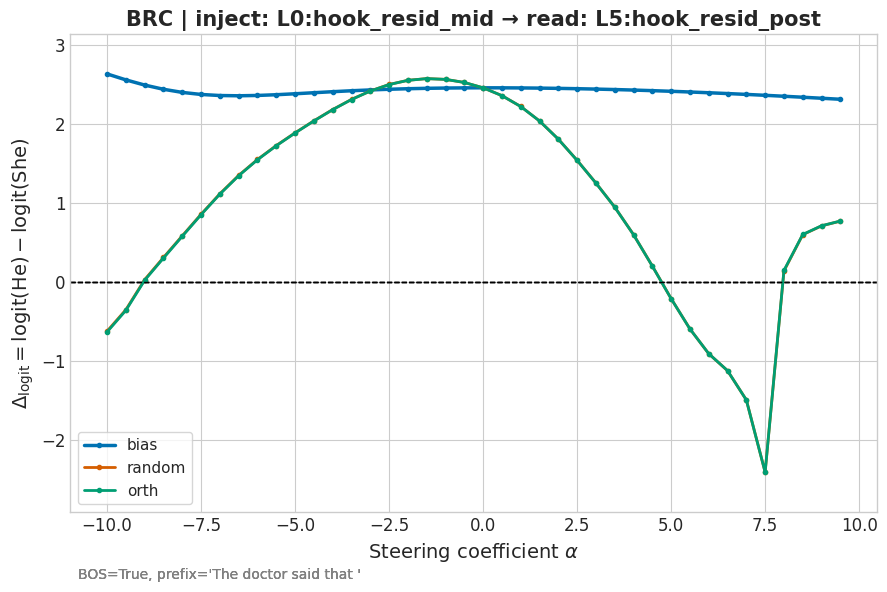

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL5_hook_resid_post.png


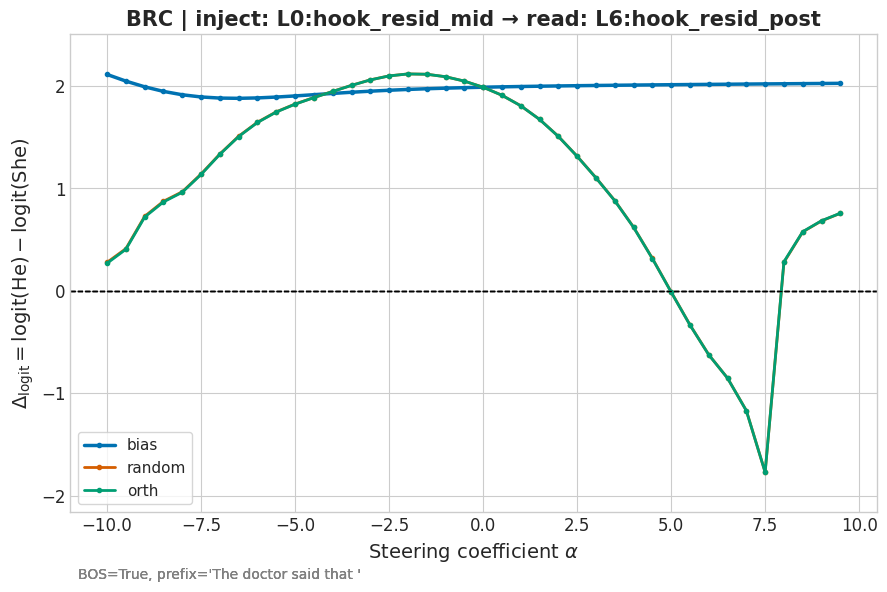

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL6_hook_resid_post.png


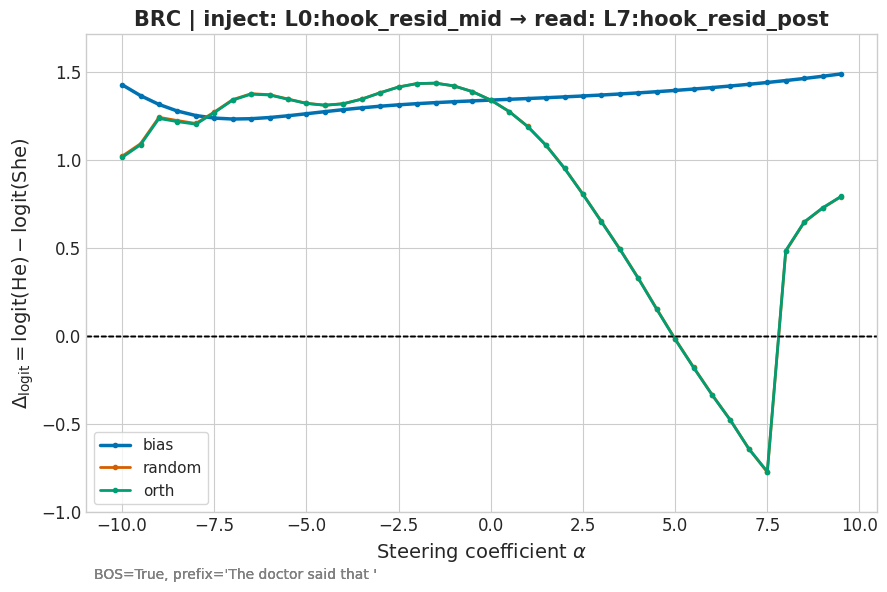

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL7_hook_resid_post.png


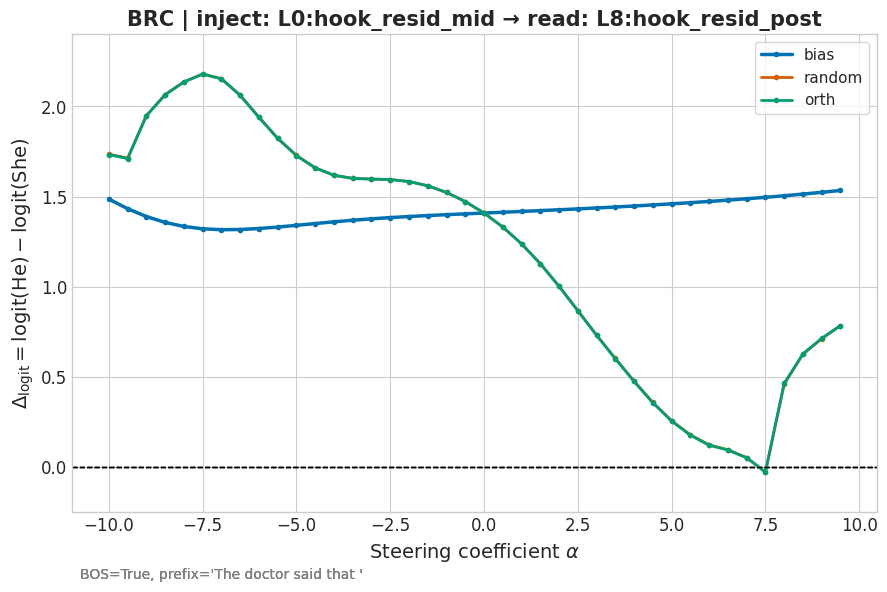

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL8_hook_resid_post.png


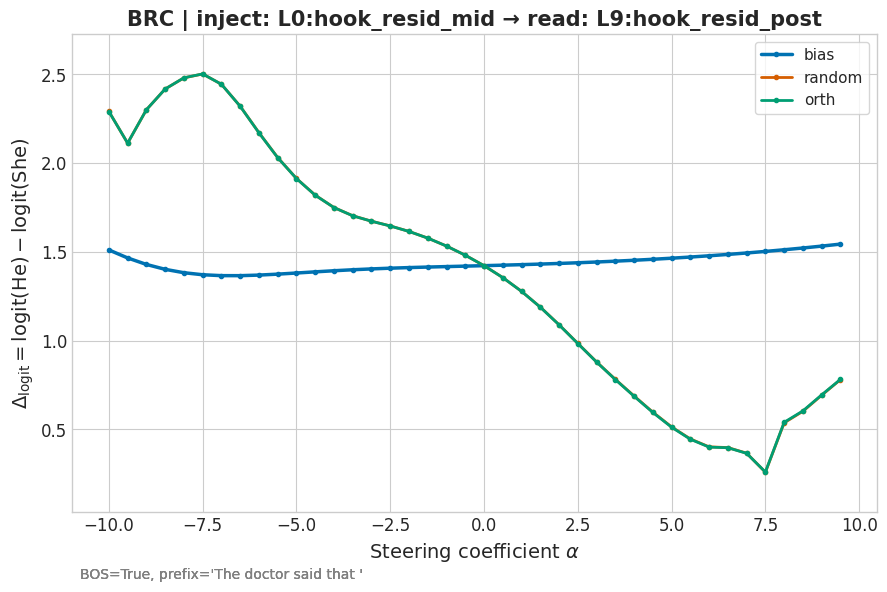

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL9_hook_resid_post.png


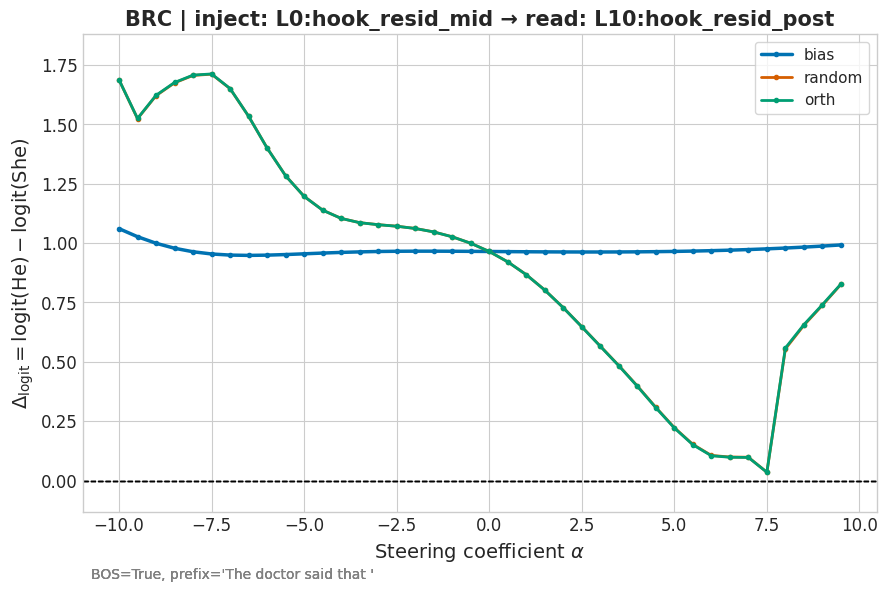

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL10_hook_resid_post.png


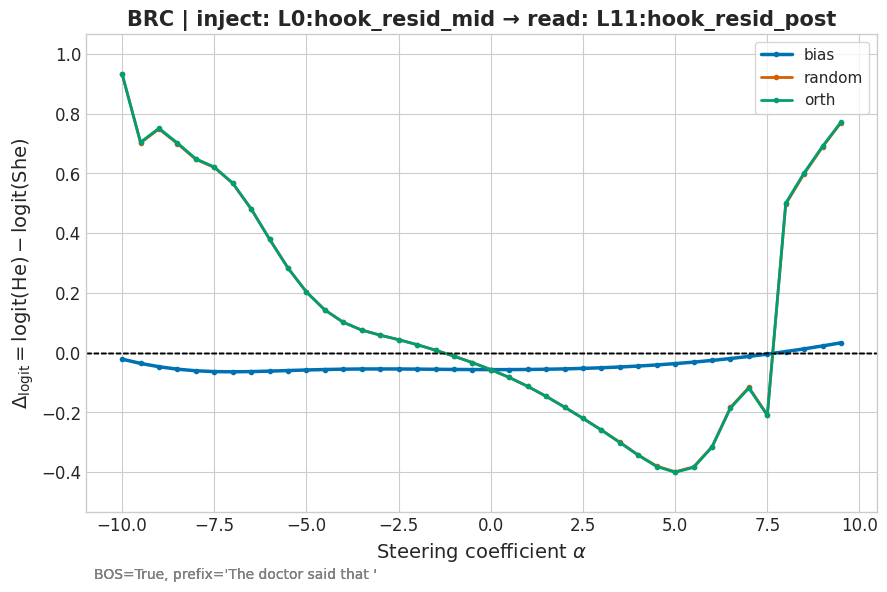

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL11_hook_resid_post.png


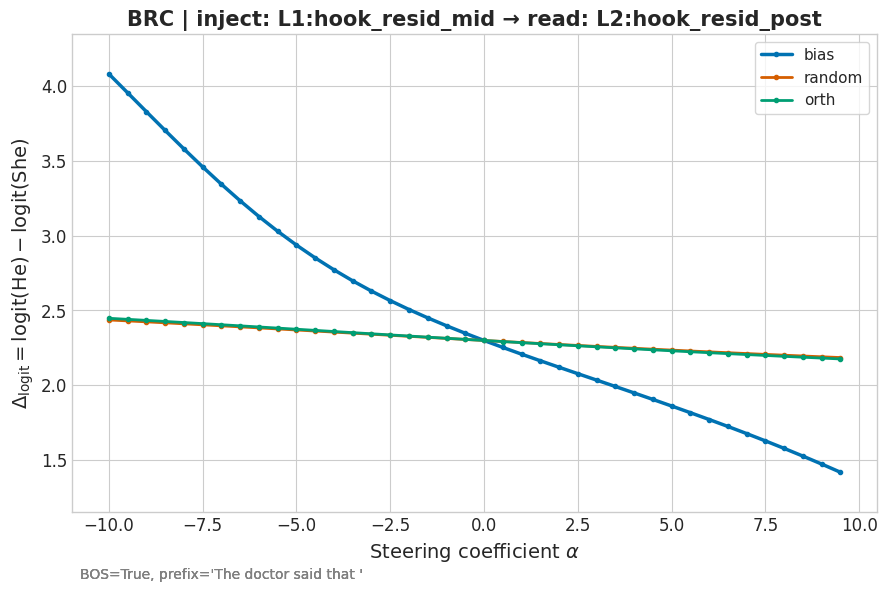

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL2_hook_resid_post.png


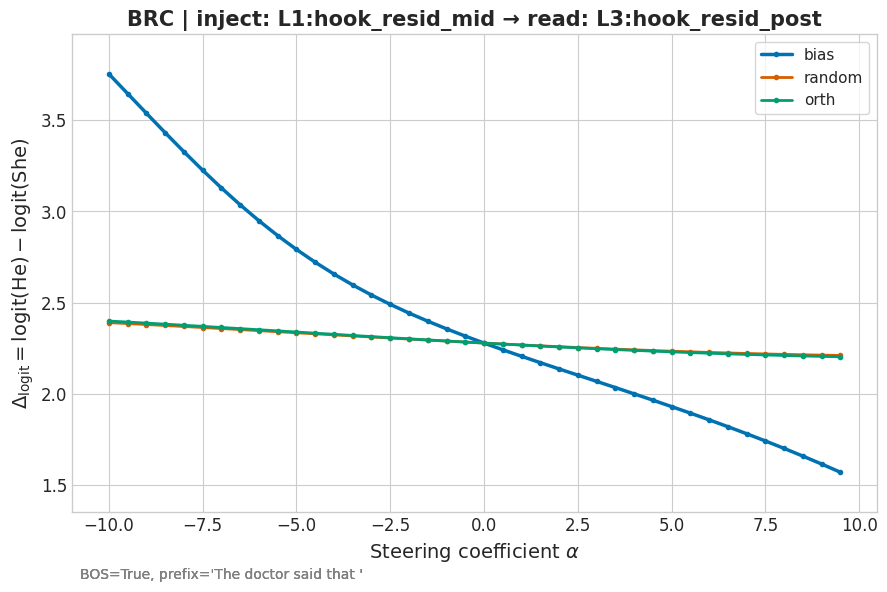

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL3_hook_resid_post.png


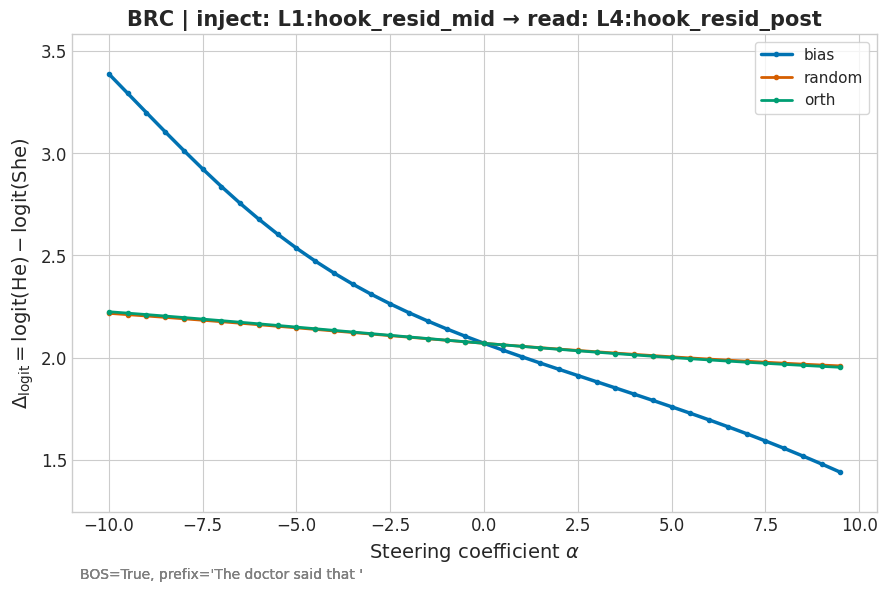

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL4_hook_resid_post.png


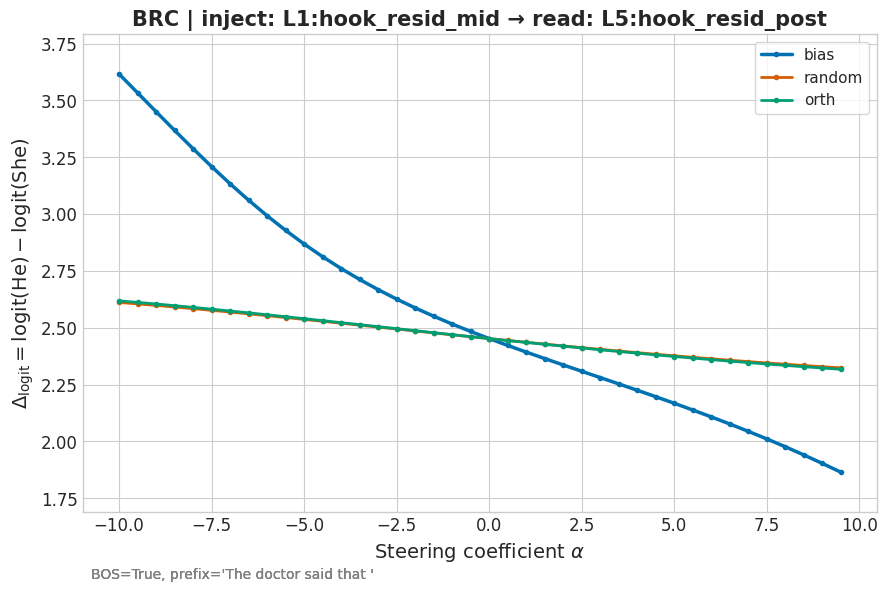

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL5_hook_resid_post.png


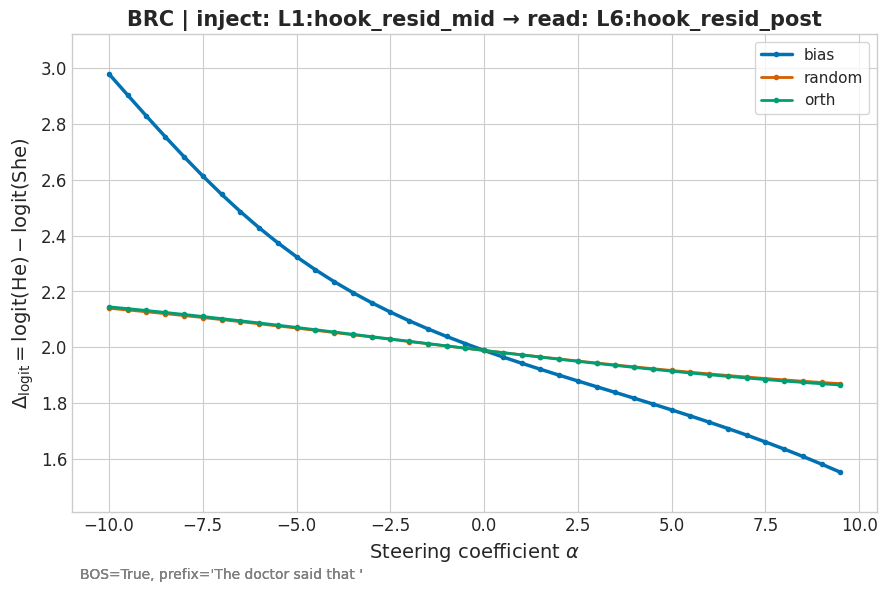

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL6_hook_resid_post.png


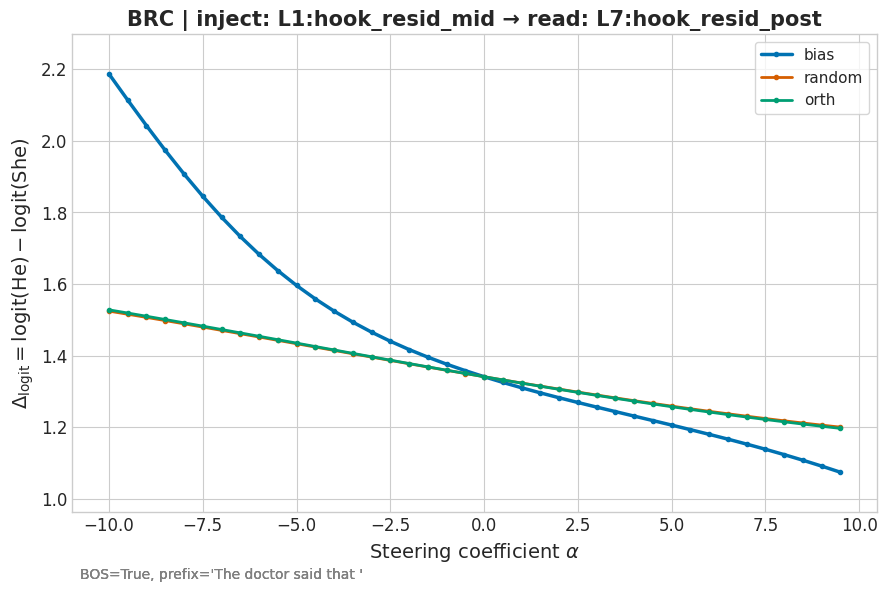

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL7_hook_resid_post.png


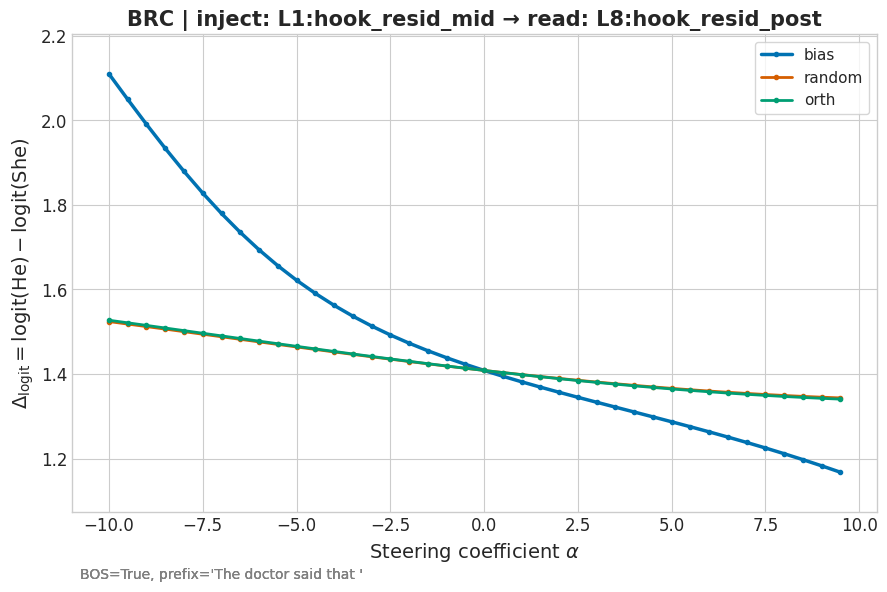

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL8_hook_resid_post.png


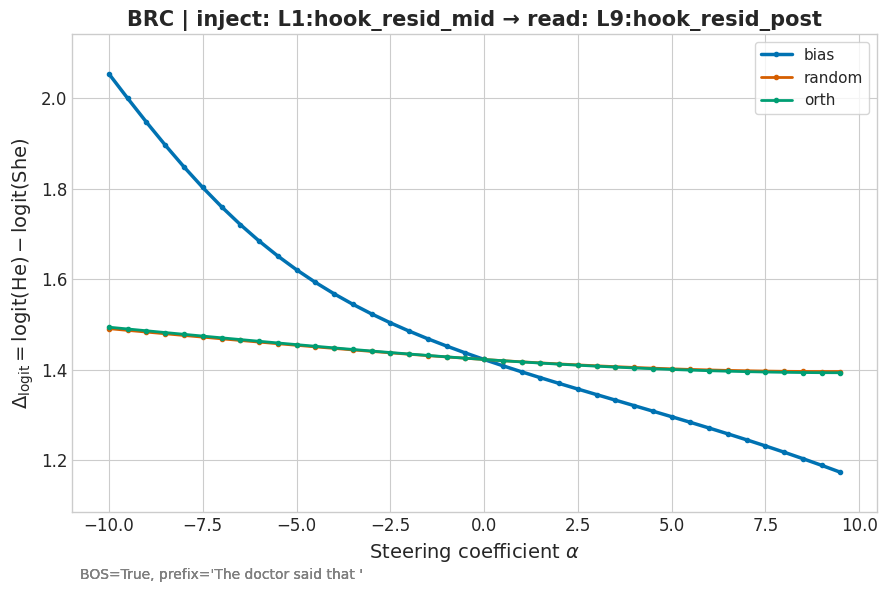

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL9_hook_resid_post.png


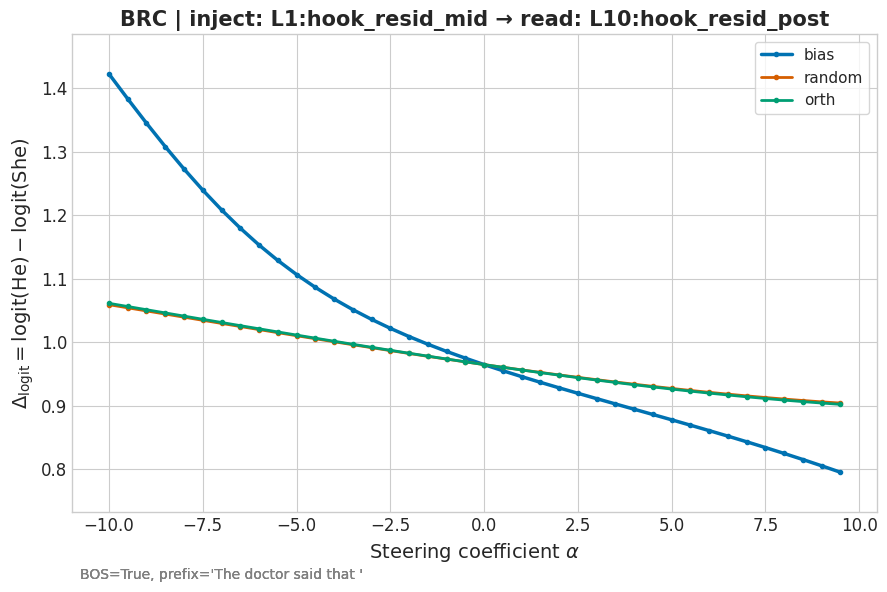

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL10_hook_resid_post.png


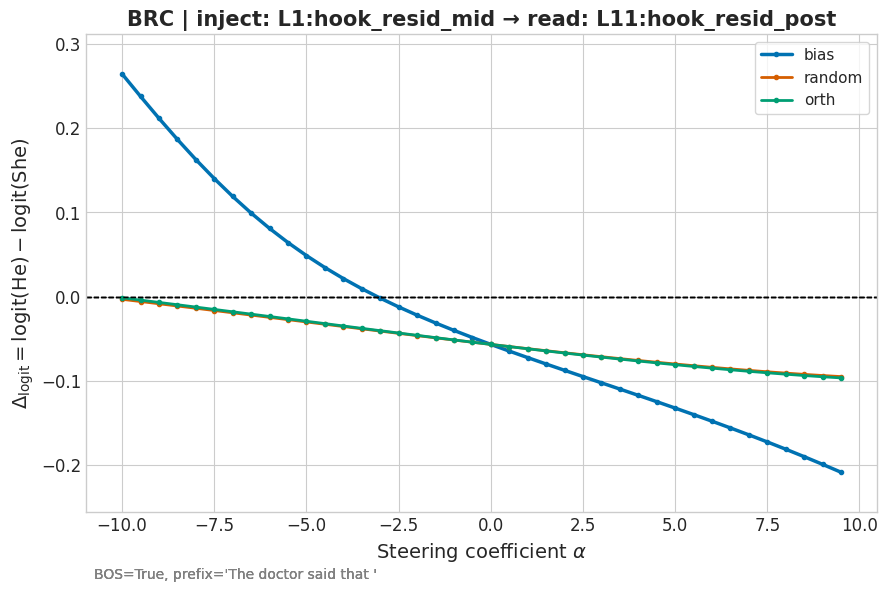

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL11_hook_resid_post.png


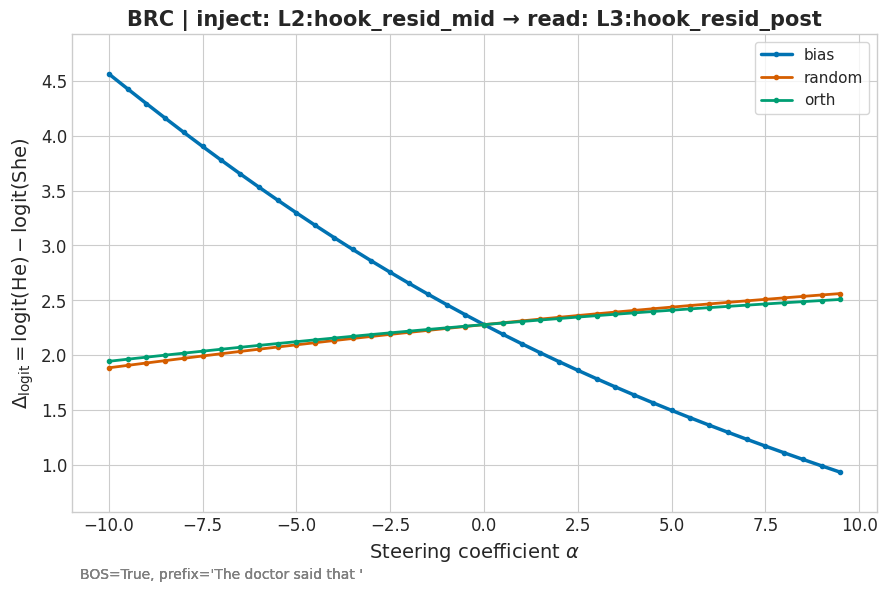

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL3_hook_resid_post.png


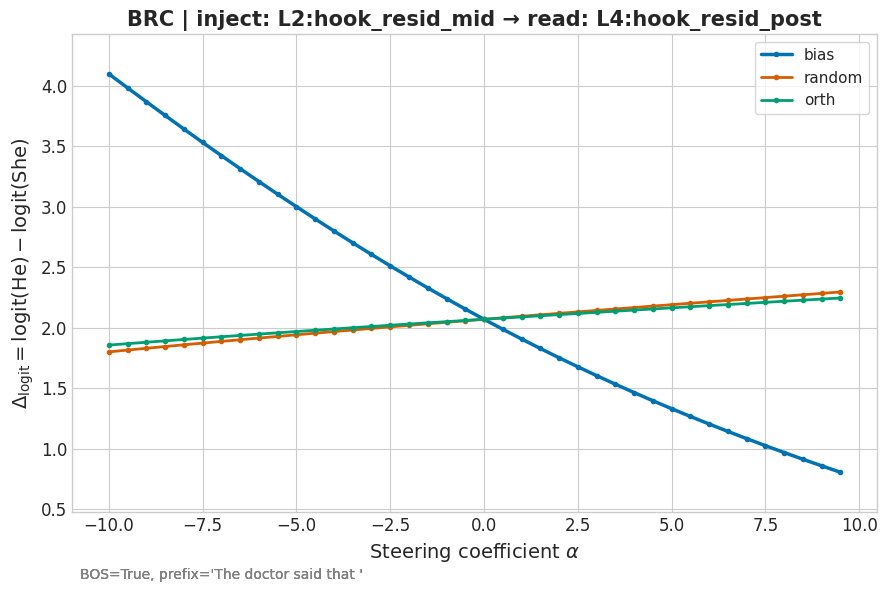

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL4_hook_resid_post.png


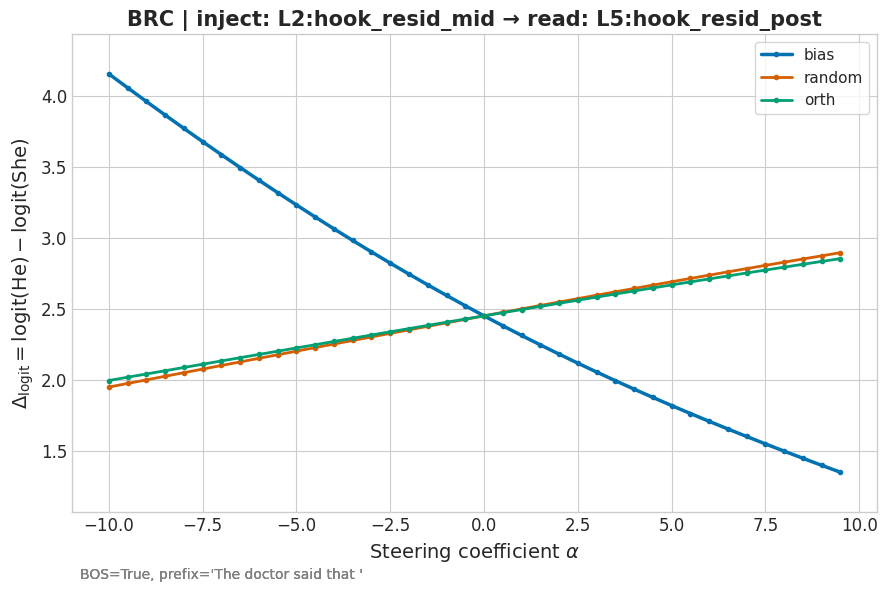

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL5_hook_resid_post.png


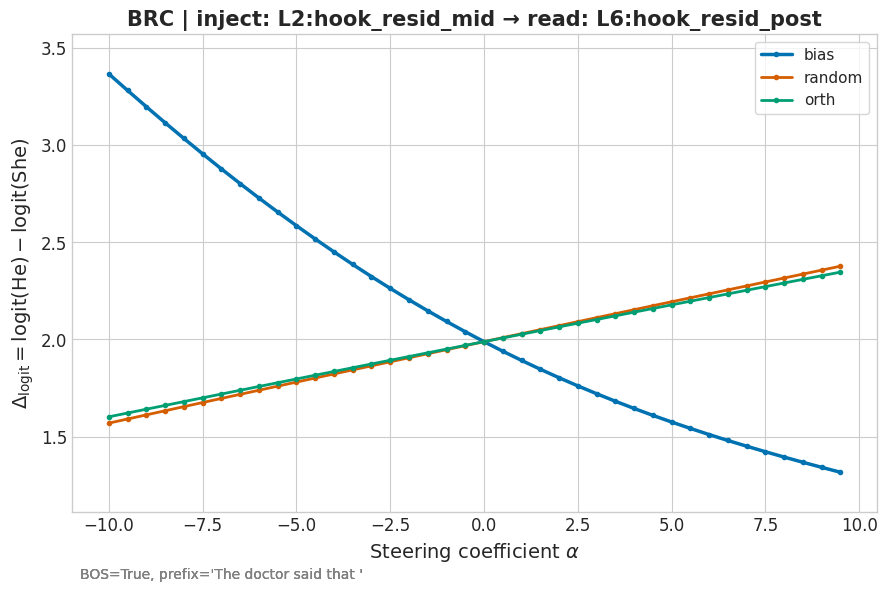

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL6_hook_resid_post.png


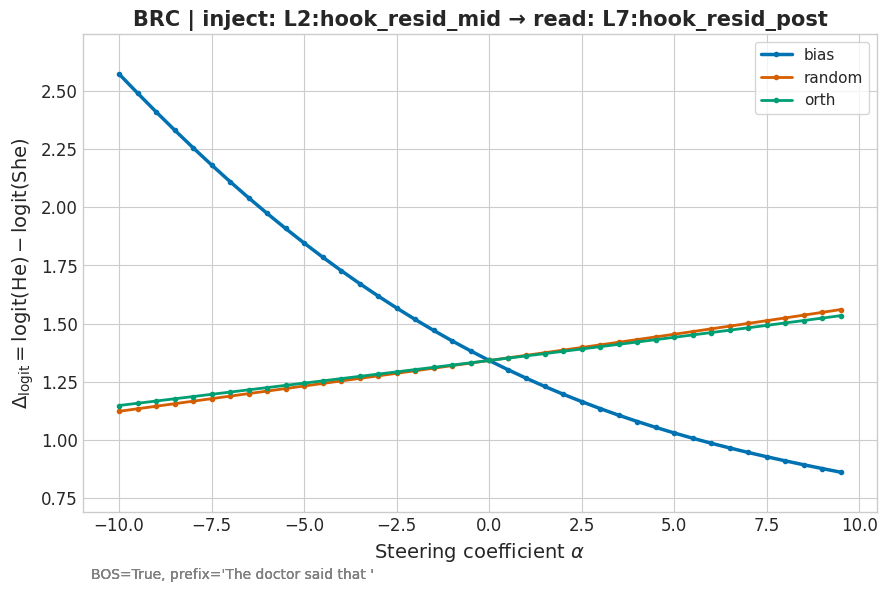

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL7_hook_resid_post.png


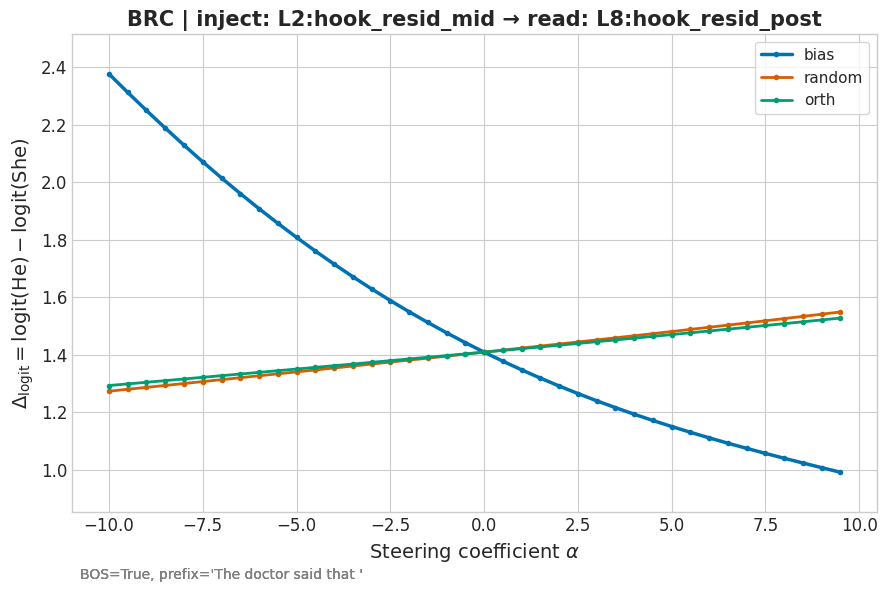

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL8_hook_resid_post.png


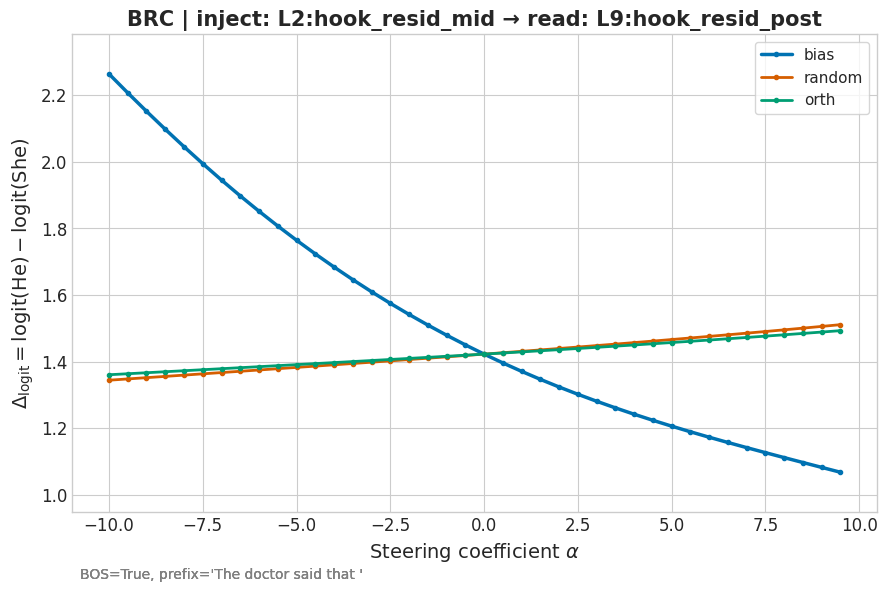

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL9_hook_resid_post.png


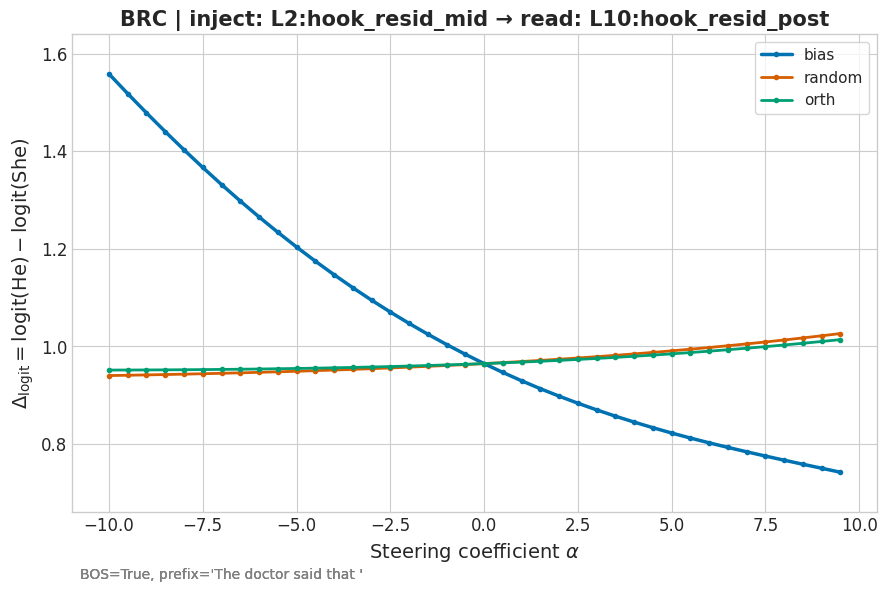

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL10_hook_resid_post.png


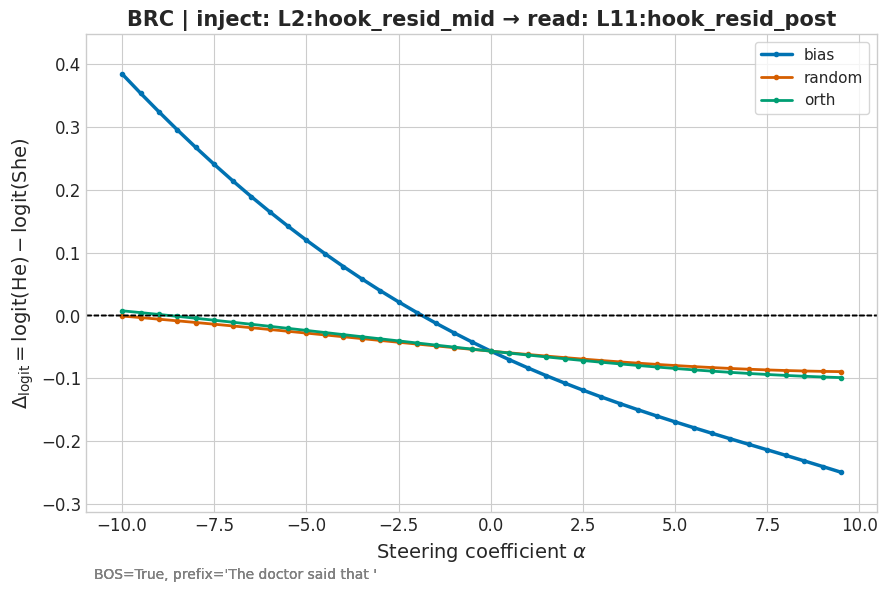

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL11_hook_resid_post.png


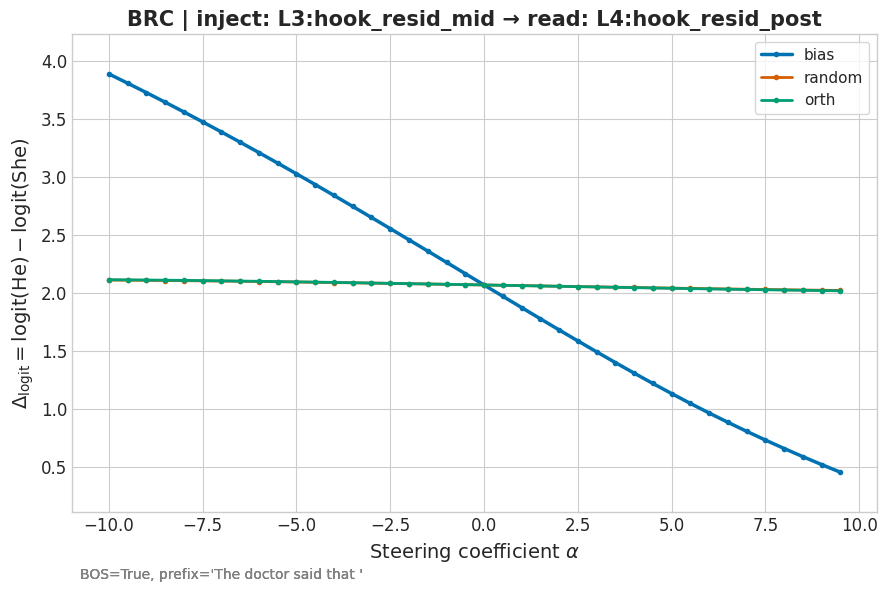

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL4_hook_resid_post.png


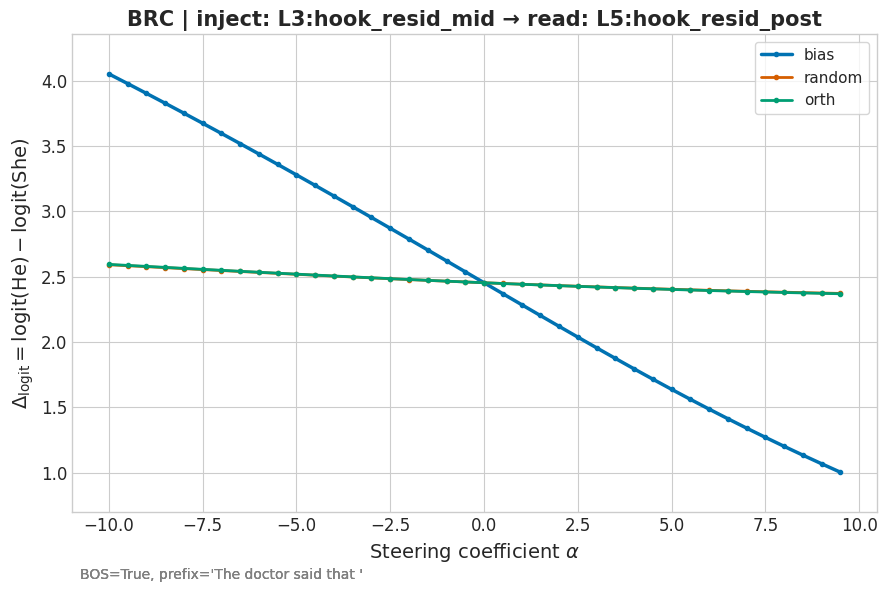

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL5_hook_resid_post.png


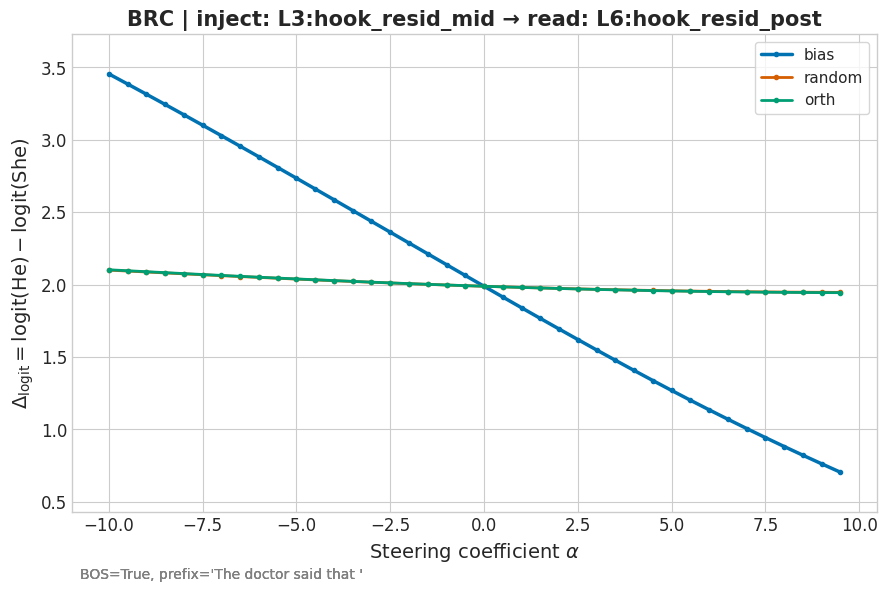

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL6_hook_resid_post.png


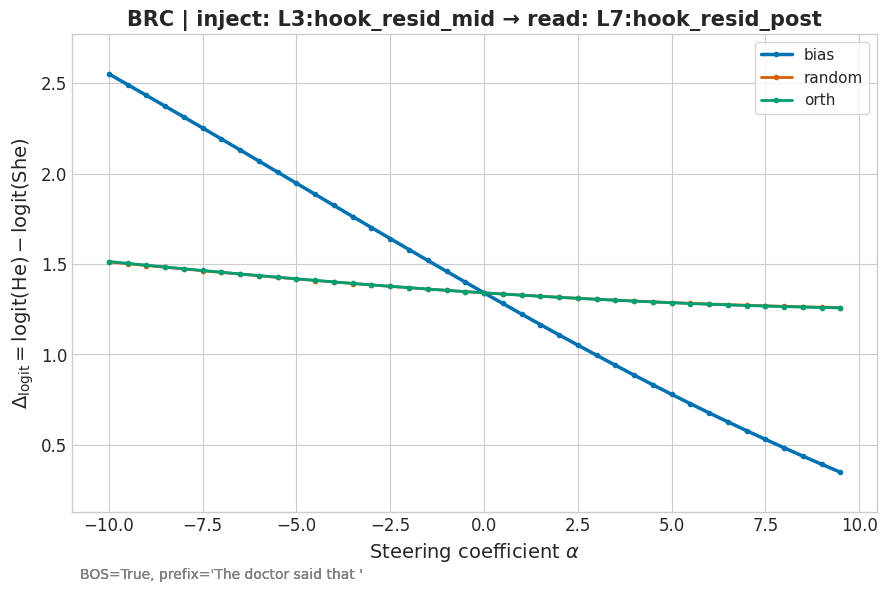

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL7_hook_resid_post.png


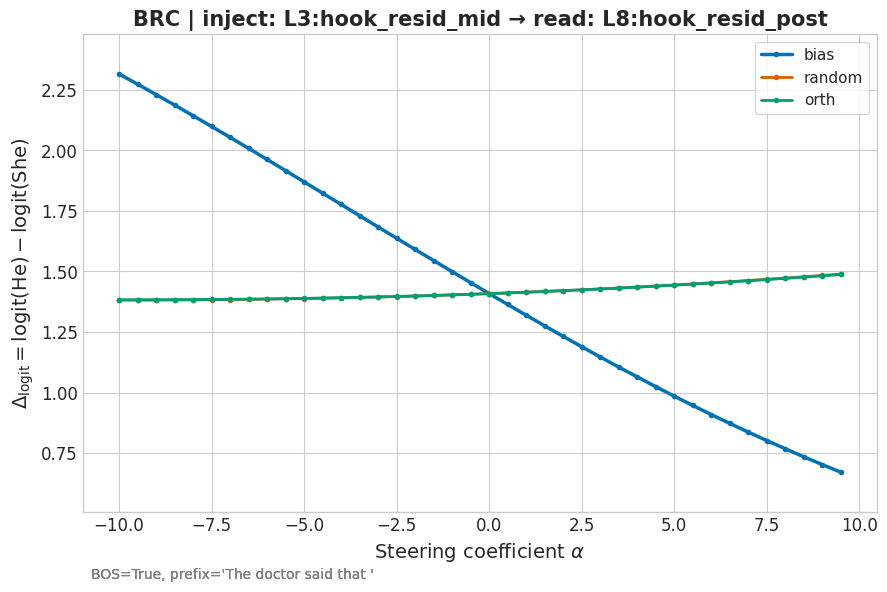

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL8_hook_resid_post.png


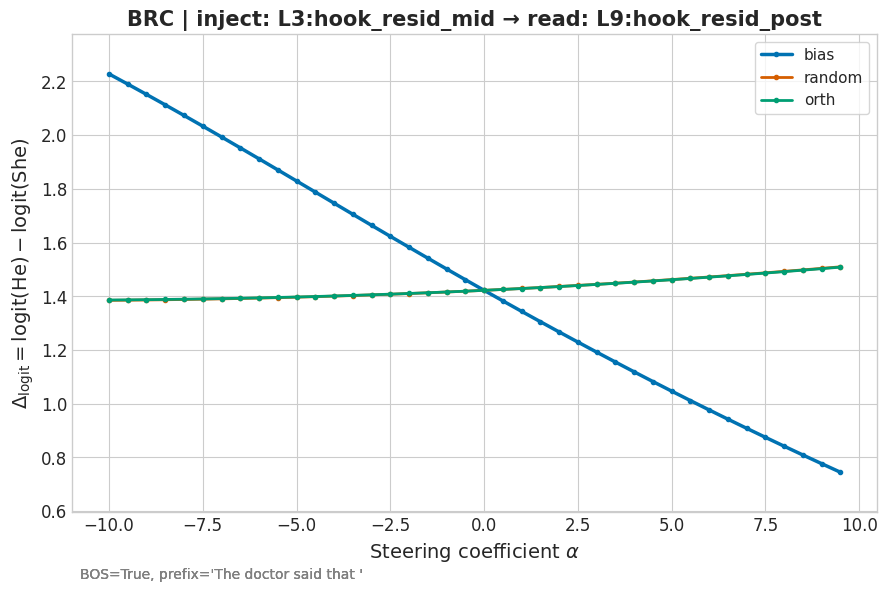

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL9_hook_resid_post.png


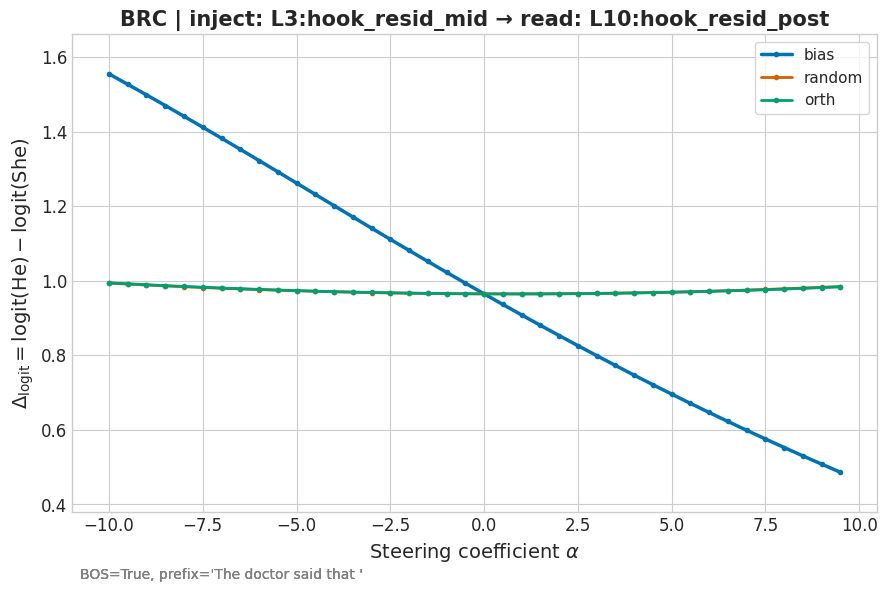

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL10_hook_resid_post.png


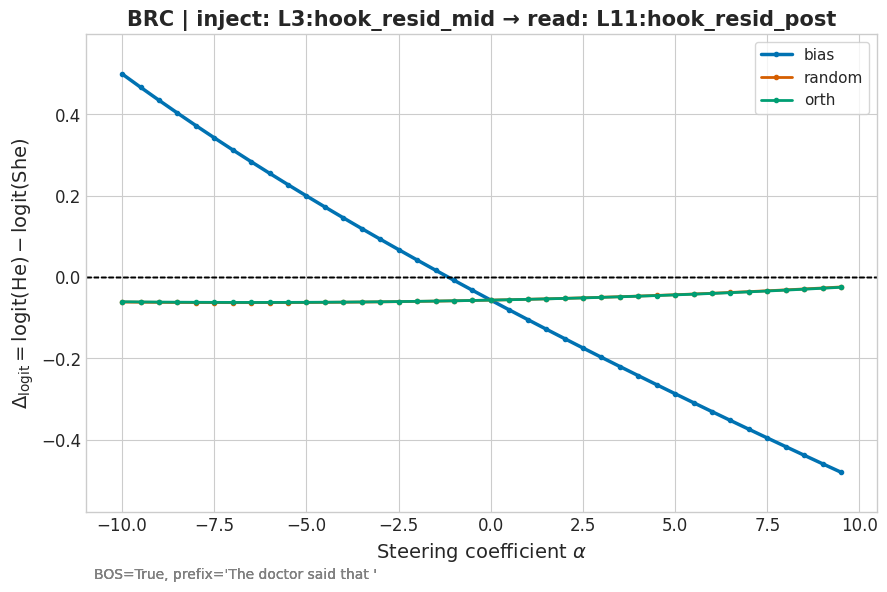

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL11_hook_resid_post.png


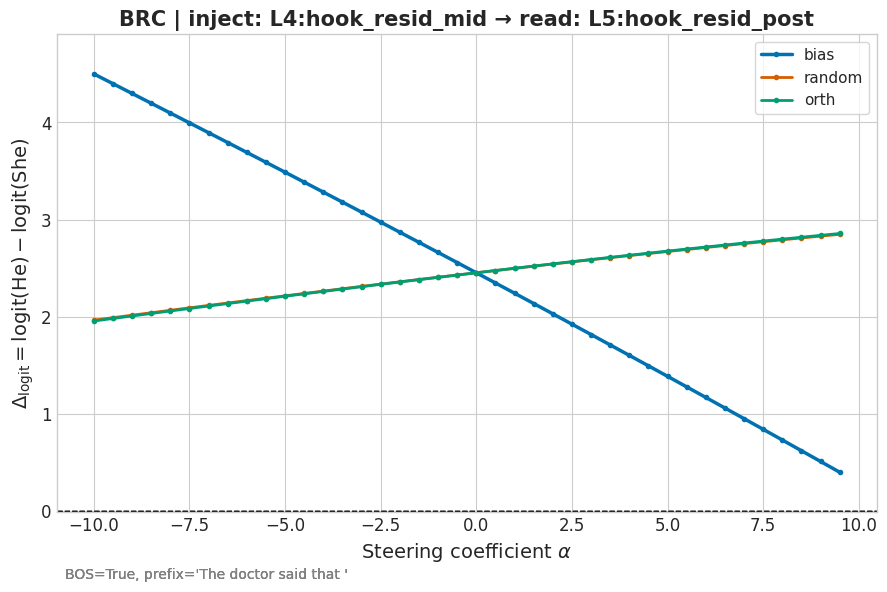

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL5_hook_resid_post.png


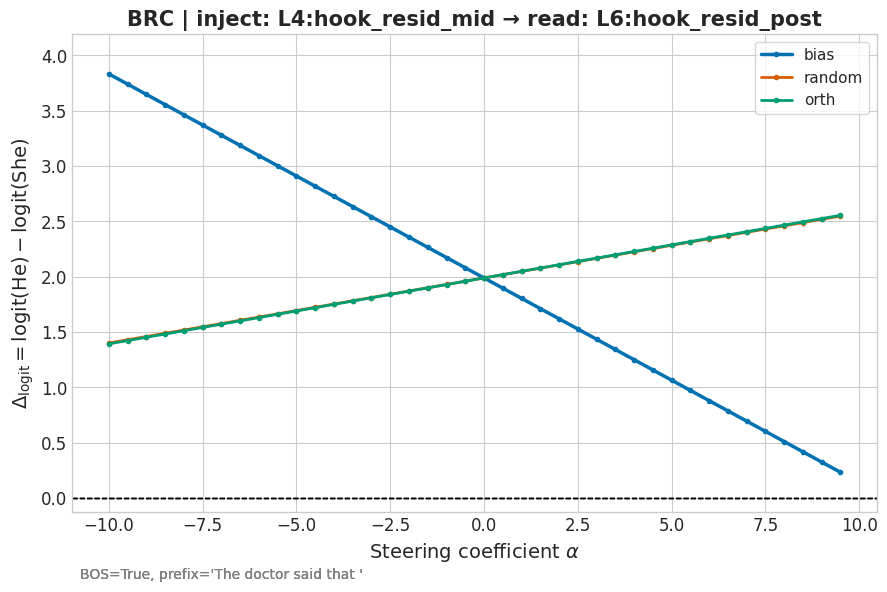

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL6_hook_resid_post.png


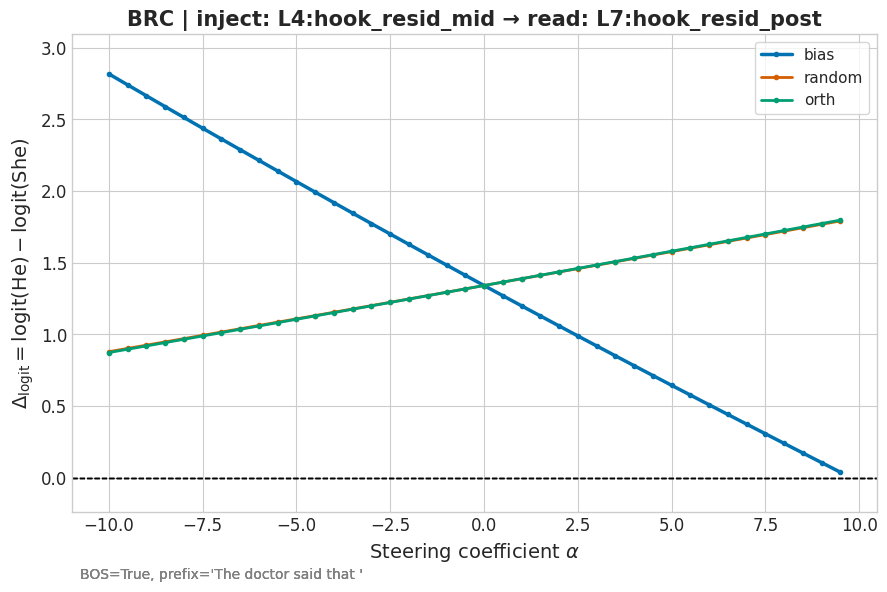

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL7_hook_resid_post.png


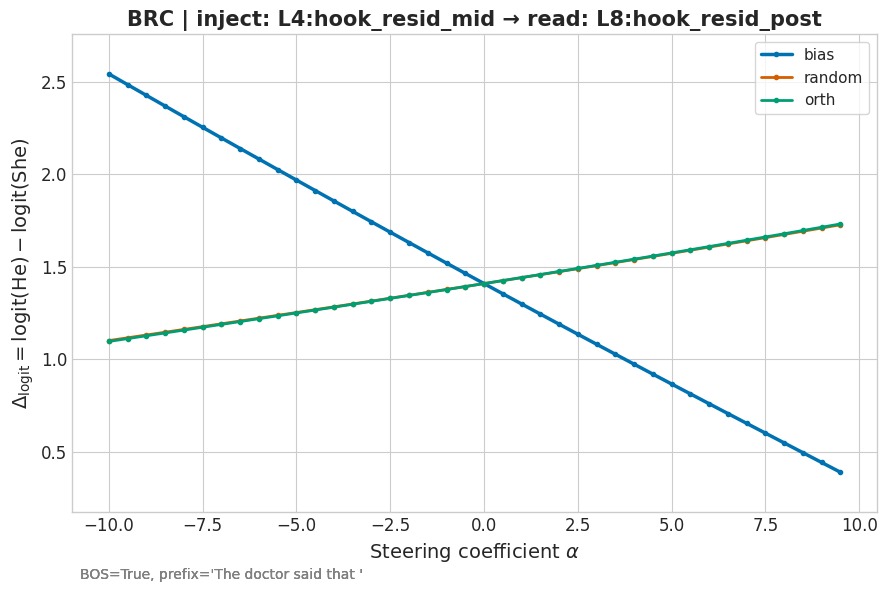

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL8_hook_resid_post.png


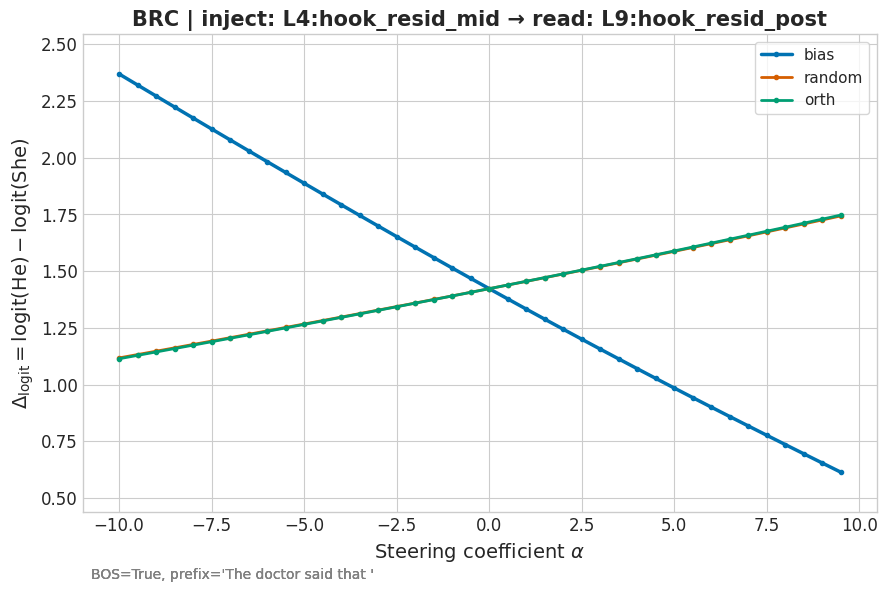

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL9_hook_resid_post.png


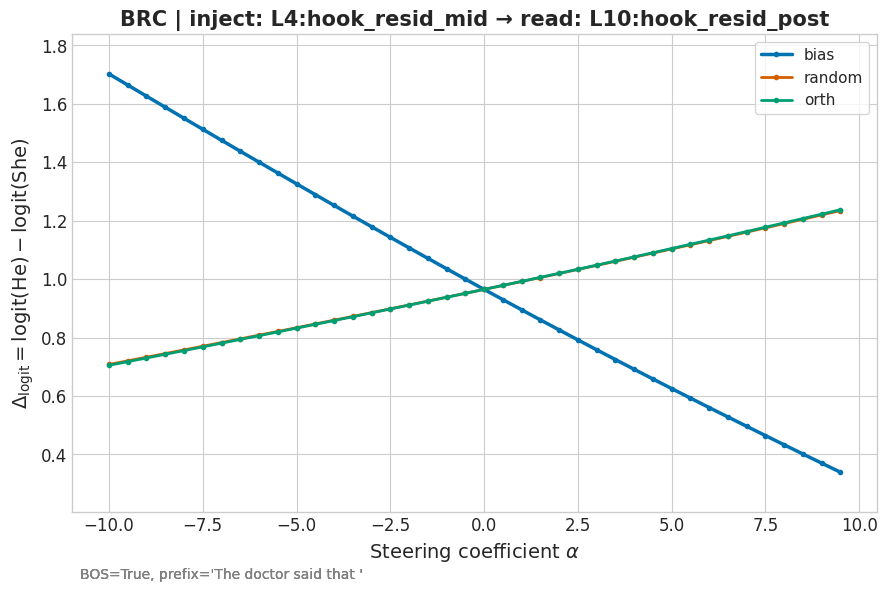

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL10_hook_resid_post.png


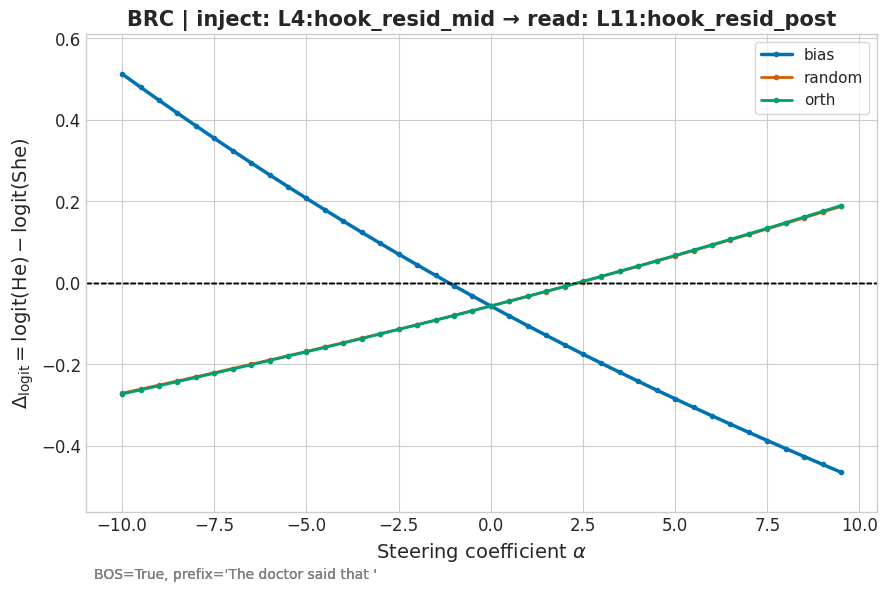

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL11_hook_resid_post.png


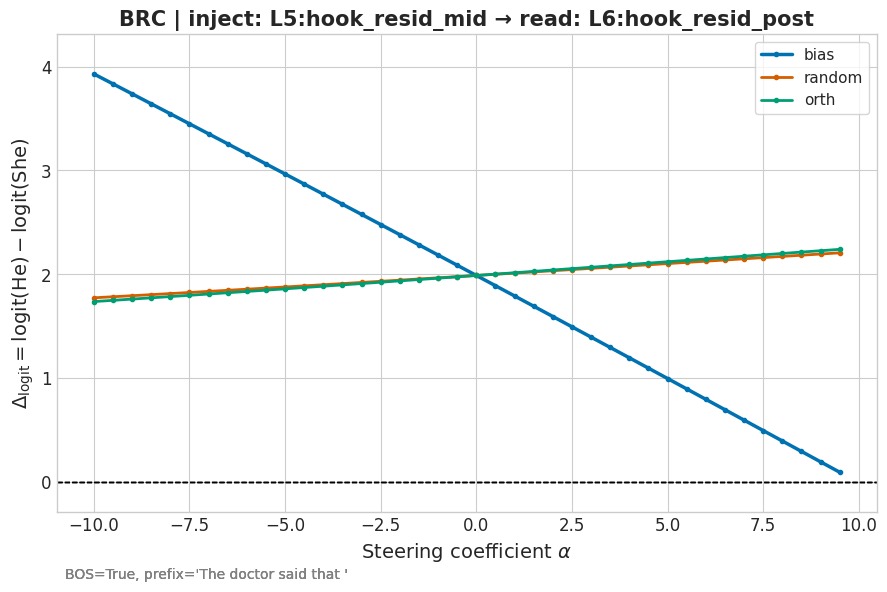

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL6_hook_resid_post.png


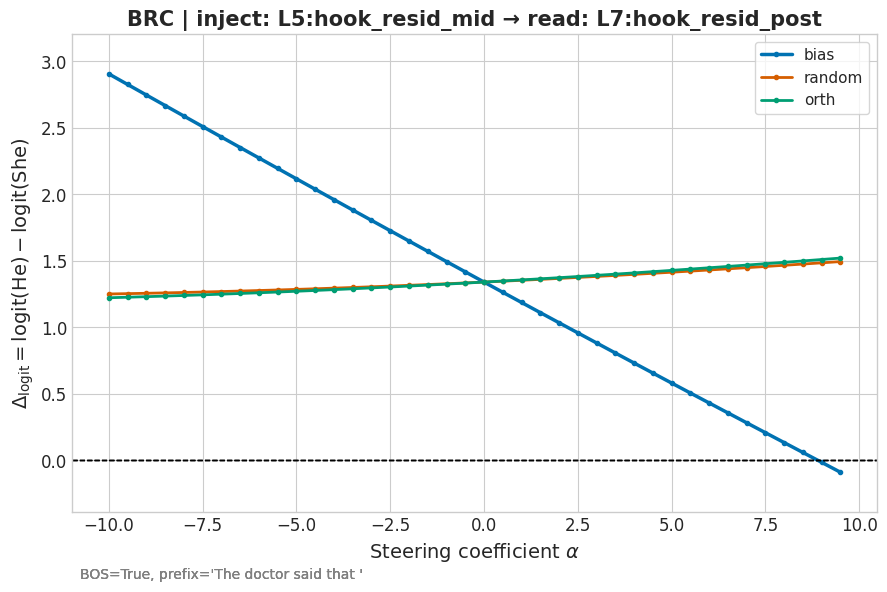

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL7_hook_resid_post.png


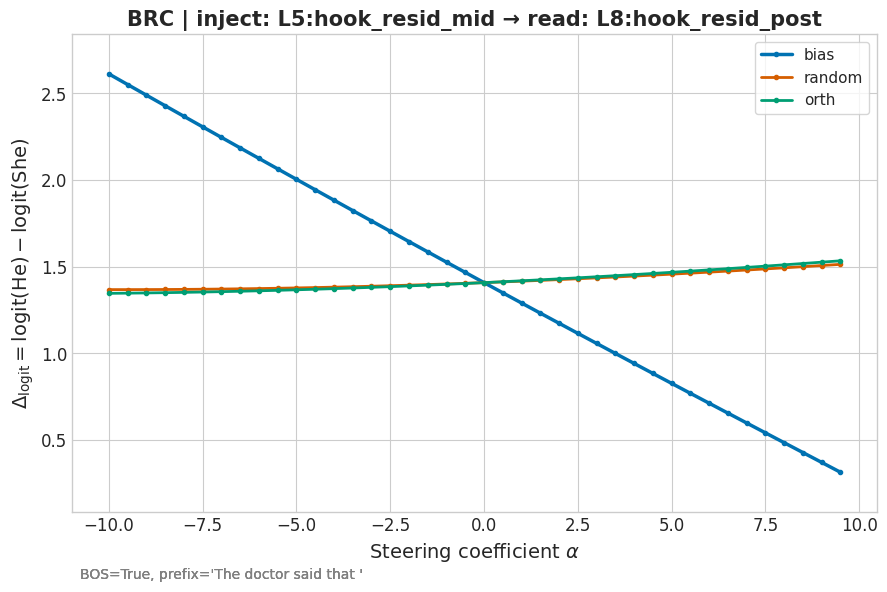

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL8_hook_resid_post.png


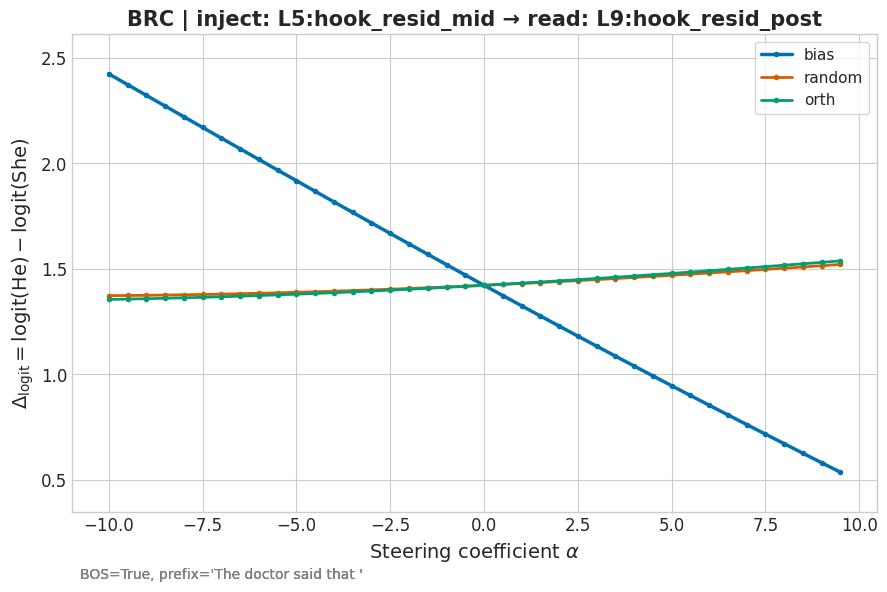

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL9_hook_resid_post.png


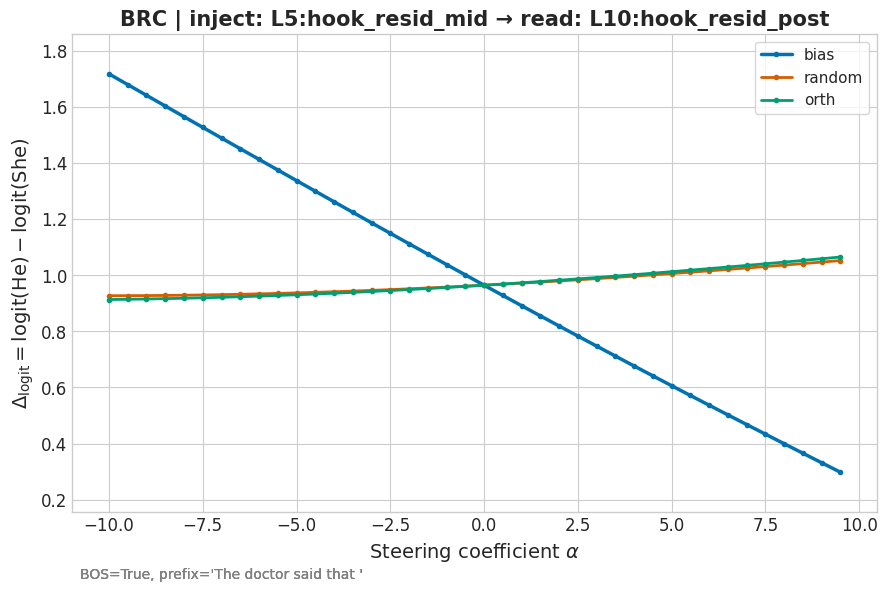

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL10_hook_resid_post.png


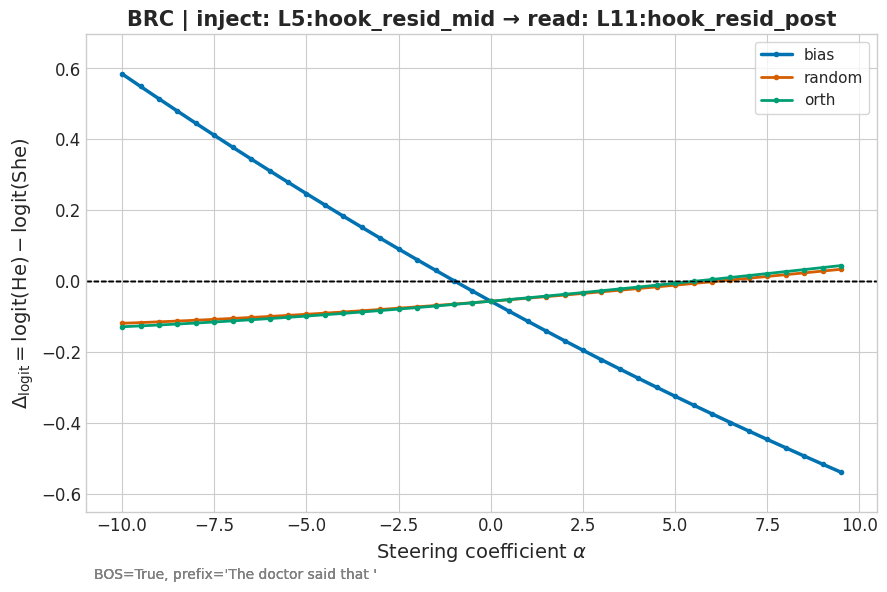

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL11_hook_resid_post.png


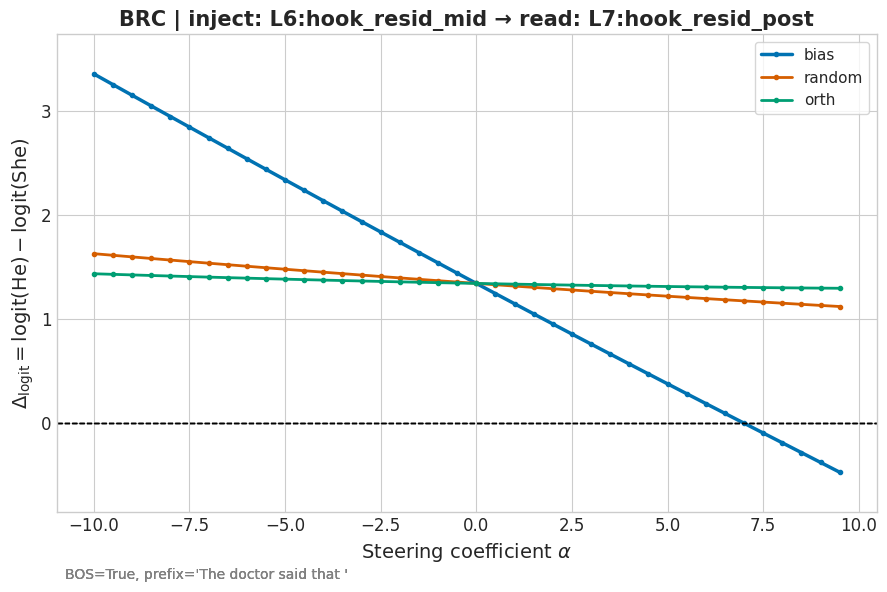

Saved: graphs/injL6/brc_injL6_hook_resid_mid_readL7_hook_resid_post.png


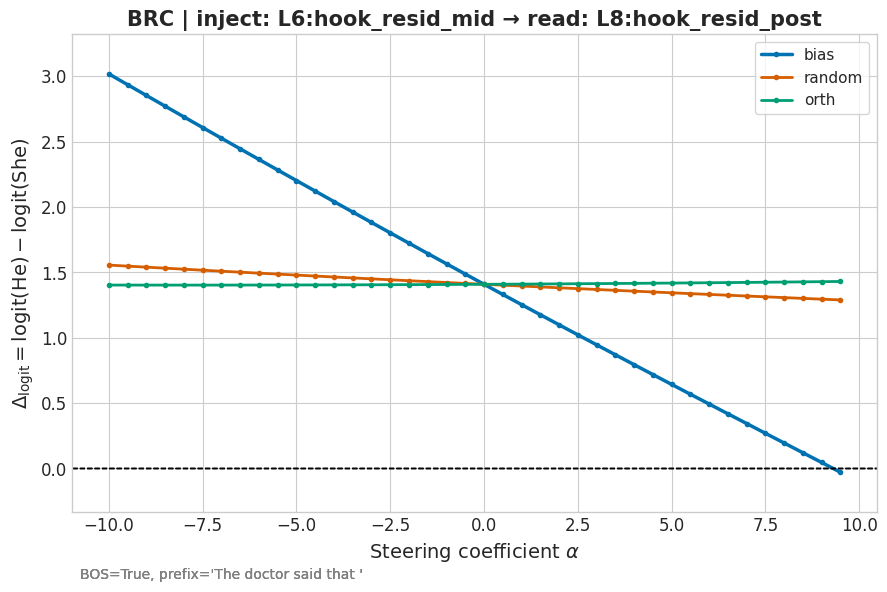

Saved: graphs/injL6/brc_injL6_hook_resid_mid_readL8_hook_resid_post.png


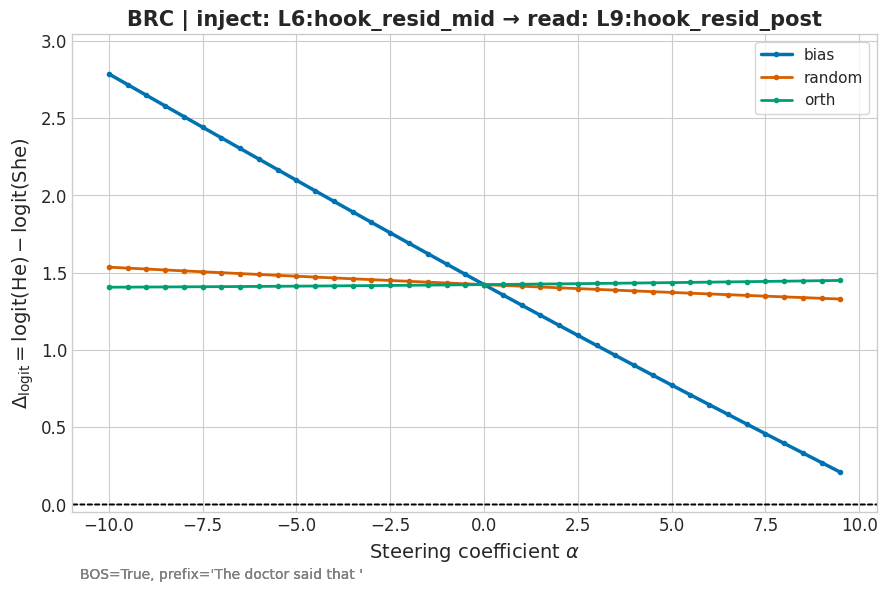

Saved: graphs/injL6/brc_injL6_hook_resid_mid_readL9_hook_resid_post.png


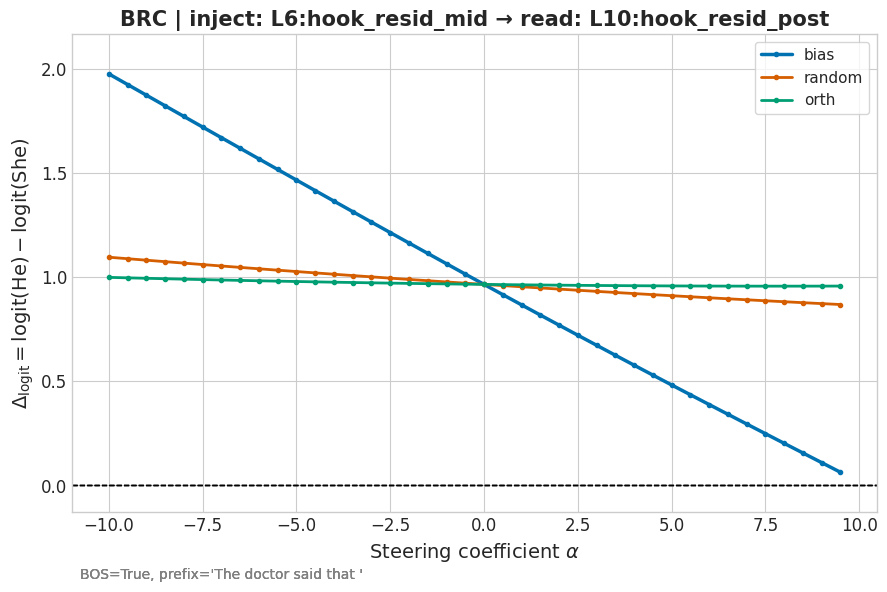

Saved: graphs/injL6/brc_injL6_hook_resid_mid_readL10_hook_resid_post.png


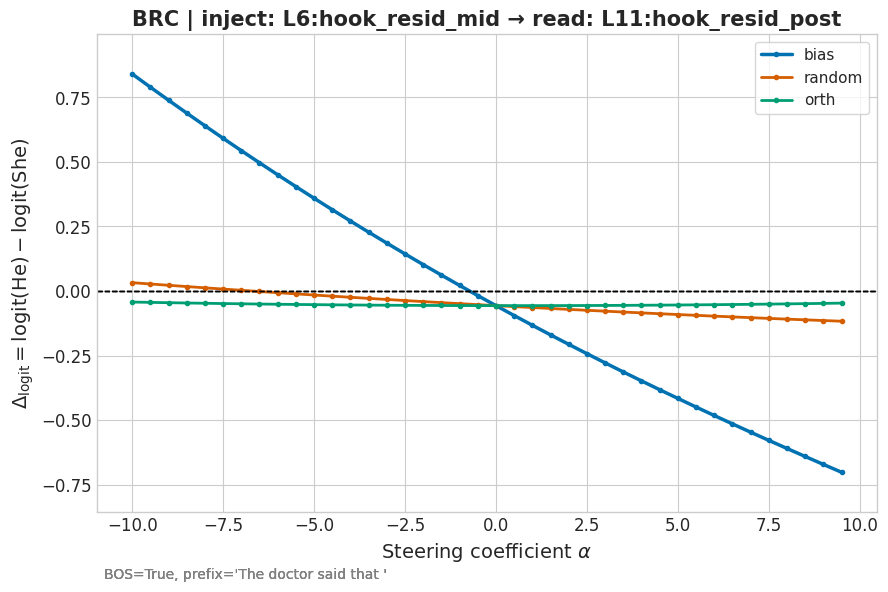

Saved: graphs/injL6/brc_injL6_hook_resid_mid_readL11_hook_resid_post.png


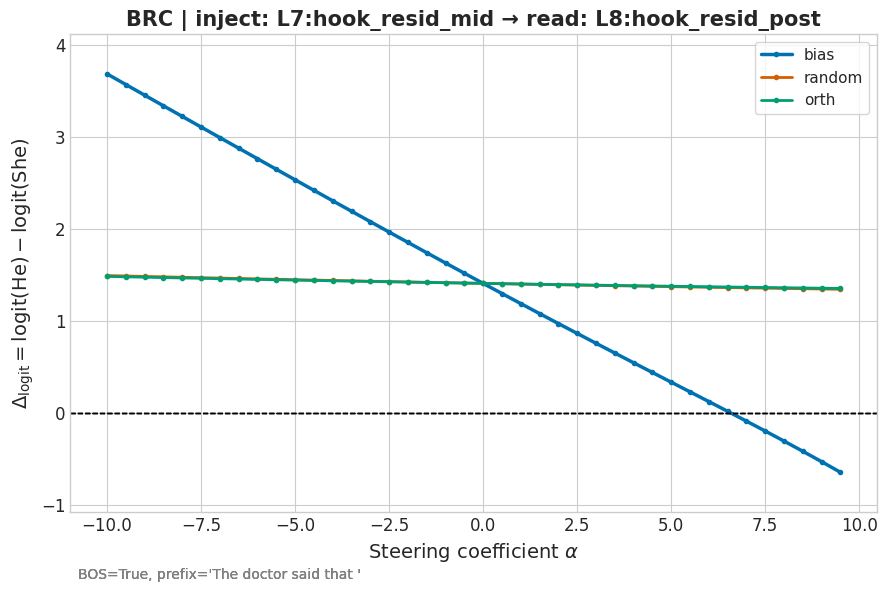

Saved: graphs/injL7/brc_injL7_hook_resid_mid_readL8_hook_resid_post.png


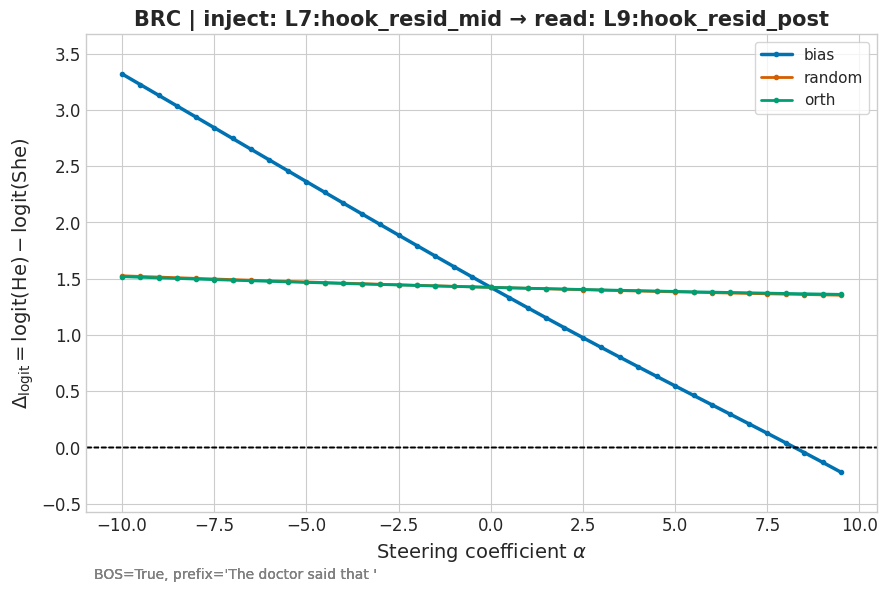

Saved: graphs/injL7/brc_injL7_hook_resid_mid_readL9_hook_resid_post.png


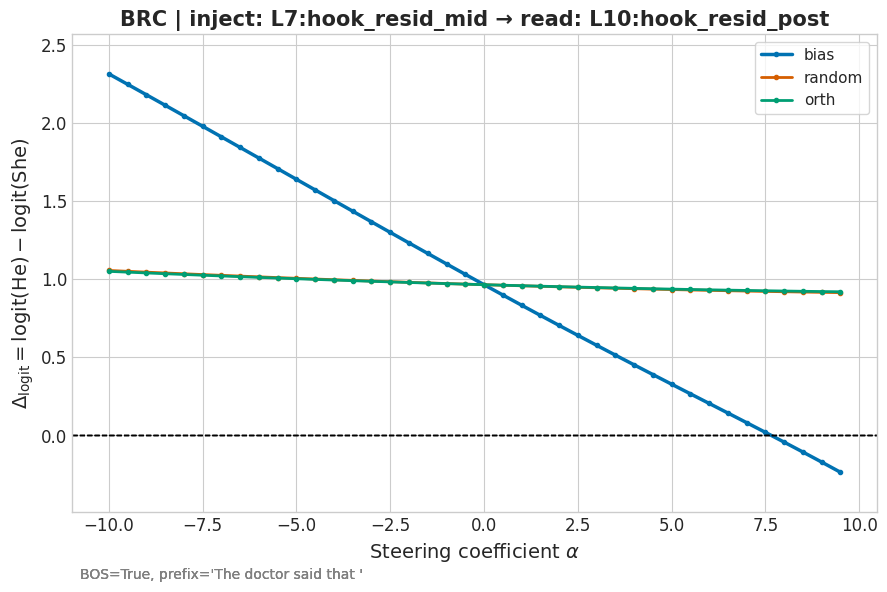

Saved: graphs/injL7/brc_injL7_hook_resid_mid_readL10_hook_resid_post.png


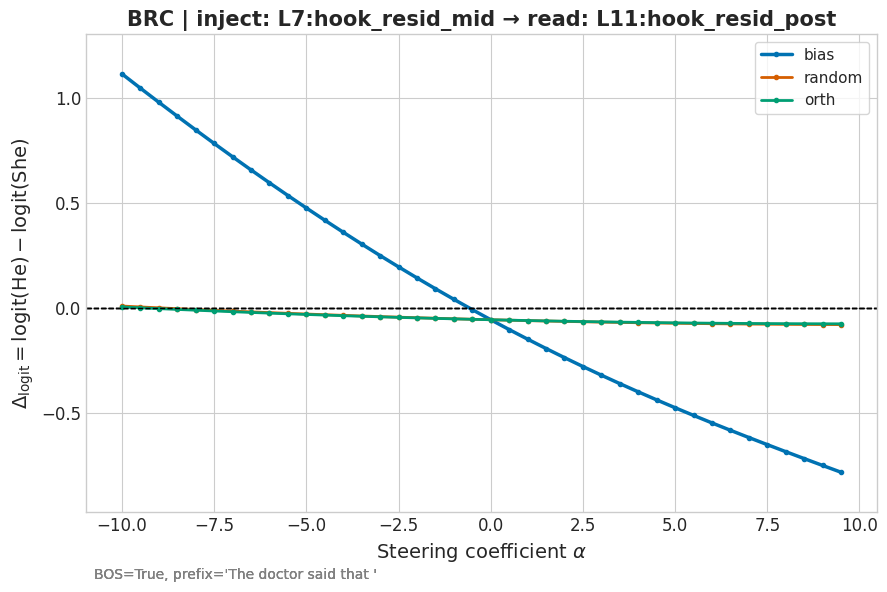

Saved: graphs/injL7/brc_injL7_hook_resid_mid_readL11_hook_resid_post.png


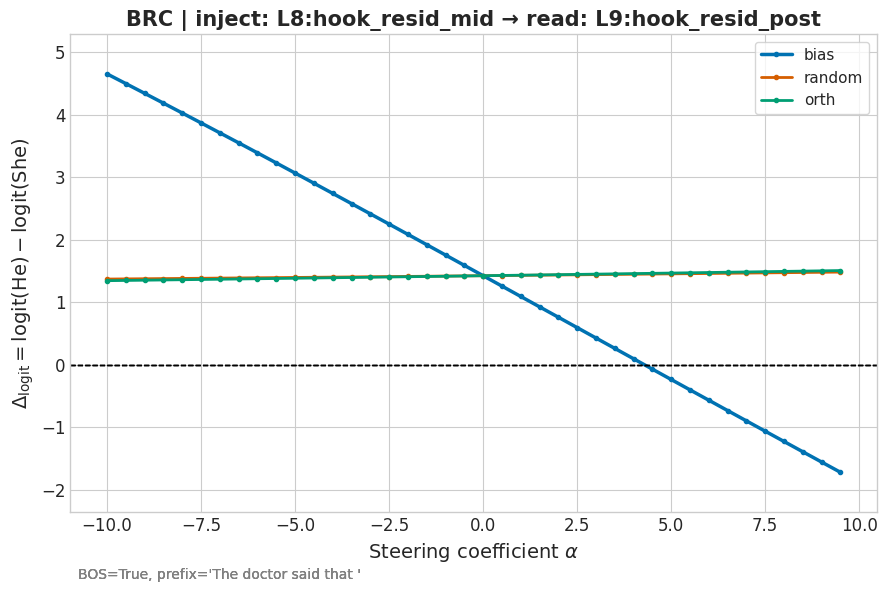

Saved: graphs/injL8/brc_injL8_hook_resid_mid_readL9_hook_resid_post.png


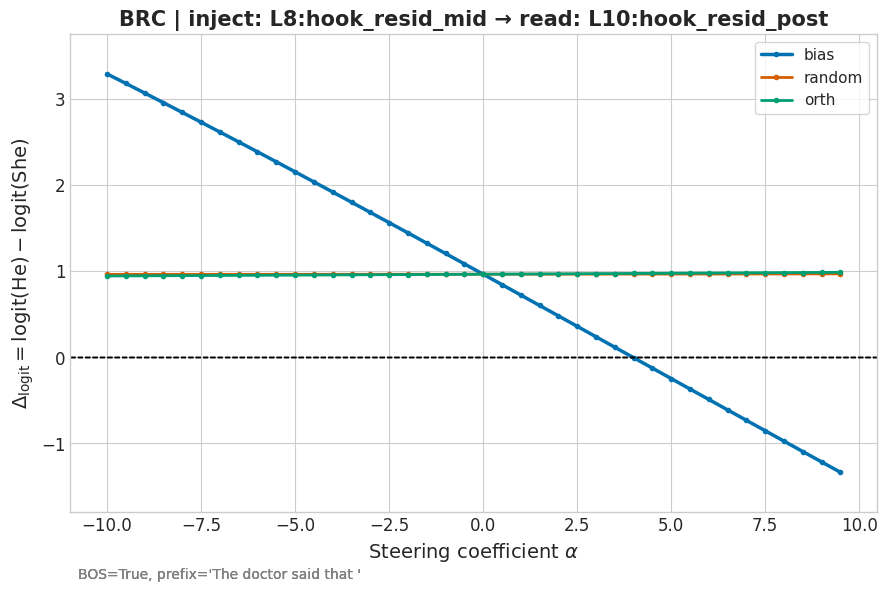

Saved: graphs/injL8/brc_injL8_hook_resid_mid_readL10_hook_resid_post.png


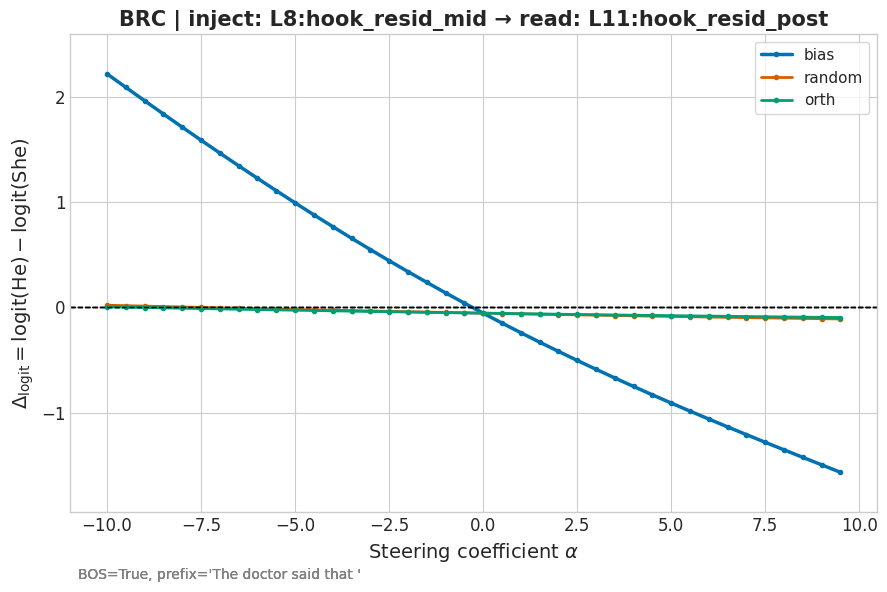

Saved: graphs/injL8/brc_injL8_hook_resid_mid_readL11_hook_resid_post.png


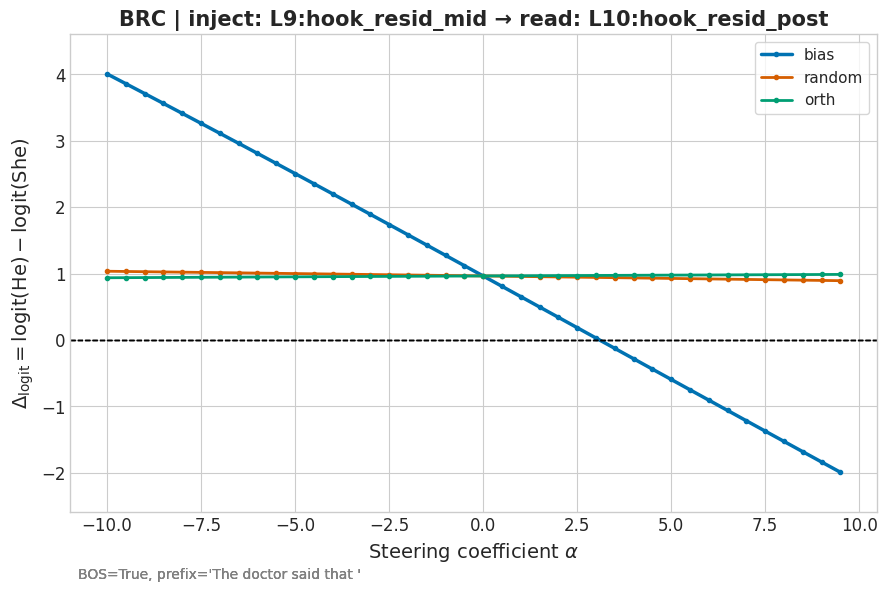

Saved: graphs/injL9/brc_injL9_hook_resid_mid_readL10_hook_resid_post.png


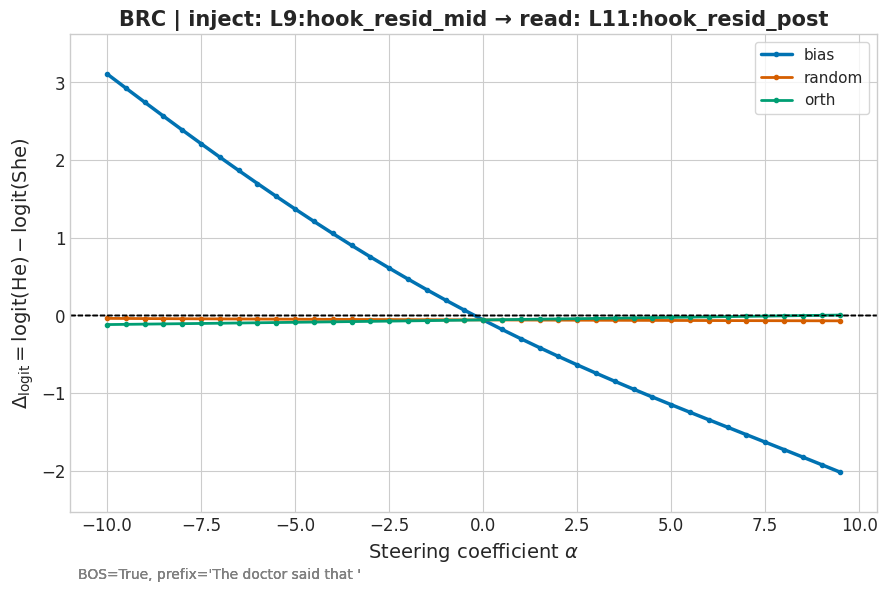

Saved: graphs/injL9/brc_injL9_hook_resid_mid_readL11_hook_resid_post.png


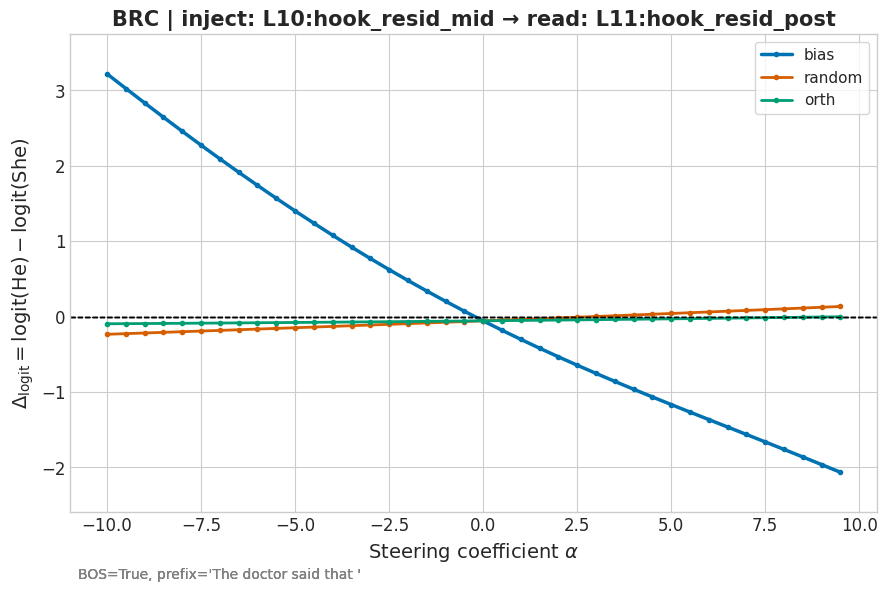

Saved: graphs/injL10/brc_injL10_hook_resid_mid_readL11_hook_resid_post.png


In [ ]:
# --- Main loop ---
def logit_diffs(logit_list): #TODO: this is a placeholder, we need to implement this properly
    """Convert a list of logits tensors to a trajectory of stereo-antistereo differences."""
    return [float((logits[he_id] - logits[she_id]).item()) for logits in logit_list]


for inj in INJECT_LAYERS:
    # vectors for this injection layer
    vectors = build_vectors(inj, prompt_pairs)

    for read in READ_LAYERS:
        if read <= inj:  # skip reading before injecting #TODO: this logic should be handled elsewhere
            continue

        inject_hook_name = f"blocks.{inj}.{INJECT_SITE}"
        read_hook_name = f"blocks.{read}.{READ_SITE}"

        # sweep alphas → logits list
        bias_logits_list = sweep_alpha(
            vectors["bias"], ALPHA_RANGE, prefix, inj, read, inject_hook_name, read_hook_name)
        random_logits_list = sweep_alpha(
            vectors["random"], ALPHA_RANGE, prefix, inj, read, inject_hook_name, read_hook_name)
        orth_logits_list = sweep_alpha(
            vectors["orth"], ALPHA_RANGE, prefix, inj, read, inject_hook_name, read_hook_name)

        # convert to Δlogit curves
        bias_diffs = logit_diffs(bias_logits_list)
        random_diffs = logit_diffs(random_logits_list)
        orth_diffs = logit_diffs(orth_logits_list)
        plot_and_save(bias_diffs, random_diffs, orth_diffs, inj, read)
